<a href="https://colab.research.google.com/github/Safaa860/BrainTumorsegmentationUnet/blob/main/LGG_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 34.1 MB/s eta 0:00:00


In [2]:
#importing libraries
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import glob  # For populating the list of files
from tqdm import tqdm


from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical,normalize


**Importing Dataset from drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unzip Dataset**

In [4]:
!unzip /content/drive/MyDrive/MICCAI_BraTS_2018_Data_Training.zip -d /content/dataset

Archive:  /content/drive/MyDrive/MICCAI_BraTS_2018_Data_Training.zip
   creating: /content/dataset/HGG/
   creating: /content/dataset/HGG/Brats18_2013_10_1/
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii.gz  
   creating: /content/dataset/HGG/Brats18_2013_11_1/
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1.nii.gz  
  inflating: /content/dataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1ce.nii.gz  
  inflating: /content/dataset/HGG/Brats1

In [5]:
#Extract path of folders
path1 = '/content/dataset/HGG'
path2 = '/content/dataset/LGG'

**Loading Dataset**

In [6]:
#eads medical image data and corresponding labels from a specific directory and returns them as arrays
def loading_dataset(path):
  my_dir = sorted(os.listdir(path))
  print("main dir length", len(my_dir))
  dataset = []
  labels = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+'/'+p))
    print('total length', len(data_list))
    # data_list = sorted(os.listdir(path+'/'+p)[:35])
    print("datalist", data_list)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[2])
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + '/' + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path +'/' + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    dataset.append([flair,t1,t1ce,t2]) #Appending images in array
    labels.append(seg) #Appending Label in array
  dataset = np.asarray(dataset,dtype=np.float32)
  labels = np.asarray(labels,dtype=np.uint8)
  return dataset,labels

In [7]:
#code is loading medical images and their labels from a dataset
lgg_data, lgg_label = loading_dataset(path2)

main dir length 75


  1%|▏         | 1/75 [00:00<00:13,  5.34it/s]

total length 5
datalist ['Brats18_2013_0_1_flair.nii.gz', 'Brats18_2013_0_1_seg.nii.gz', 'Brats18_2013_0_1_t1.nii.gz', 'Brats18_2013_0_1_t1ce.nii.gz', 'Brats18_2013_0_1_t2.nii.gz']
total length 5
datalist ['Brats18_2013_15_1_flair.nii.gz', 'Brats18_2013_15_1_seg.nii.gz', 'Brats18_2013_15_1_t1.nii.gz', 'Brats18_2013_15_1_t1ce.nii.gz', 'Brats18_2013_15_1_t2.nii.gz']


  4%|▍         | 3/75 [00:00<00:12,  5.77it/s]

total length 5
datalist ['Brats18_2013_16_1_flair.nii.gz', 'Brats18_2013_16_1_seg.nii.gz', 'Brats18_2013_16_1_t1.nii.gz', 'Brats18_2013_16_1_t1ce.nii.gz', 'Brats18_2013_16_1_t2.nii.gz']
total length 5
datalist ['Brats18_2013_1_1_flair.nii.gz', 'Brats18_2013_1_1_seg.nii.gz', 'Brats18_2013_1_1_t1.nii.gz', 'Brats18_2013_1_1_t1ce.nii.gz', 'Brats18_2013_1_1_t2.nii.gz']


  7%|▋         | 5/75 [00:00<00:11,  6.21it/s]

total length 5
datalist ['Brats18_2013_24_1_flair.nii.gz', 'Brats18_2013_24_1_seg.nii.gz', 'Brats18_2013_24_1_t1.nii.gz', 'Brats18_2013_24_1_t1ce.nii.gz', 'Brats18_2013_24_1_t2.nii.gz']
total length 5
datalist ['Brats18_2013_28_1_flair.nii.gz', 'Brats18_2013_28_1_seg.nii.gz', 'Brats18_2013_28_1_t1.nii.gz', 'Brats18_2013_28_1_t1ce.nii.gz', 'Brats18_2013_28_1_t2.nii.gz']


  9%|▉         | 7/75 [00:01<00:10,  6.45it/s]

total length 5
datalist ['Brats18_2013_29_1_flair.nii.gz', 'Brats18_2013_29_1_seg.nii.gz', 'Brats18_2013_29_1_t1.nii.gz', 'Brats18_2013_29_1_t1ce.nii.gz', 'Brats18_2013_29_1_t2.nii.gz']
total length 5
datalist ['Brats18_2013_6_1_flair.nii.gz', 'Brats18_2013_6_1_seg.nii.gz', 'Brats18_2013_6_1_t1.nii.gz', 'Brats18_2013_6_1_t1ce.nii.gz', 'Brats18_2013_6_1_t2.nii.gz']


 12%|█▏        | 9/75 [00:01<00:10,  6.35it/s]

total length 5
datalist ['Brats18_2013_8_1_flair.nii.gz', 'Brats18_2013_8_1_seg.nii.gz', 'Brats18_2013_8_1_t1.nii.gz', 'Brats18_2013_8_1_t1ce.nii.gz', 'Brats18_2013_8_1_t2.nii.gz']
total length 5
datalist ['Brats18_2013_9_1_flair.nii.gz', 'Brats18_2013_9_1_seg.nii.gz', 'Brats18_2013_9_1_t1.nii.gz', 'Brats18_2013_9_1_t1ce.nii.gz', 'Brats18_2013_9_1_t2.nii.gz']


 15%|█▍        | 11/75 [00:01<00:10,  6.33it/s]

total length 5
datalist ['Brats18_TCIA09_141_1_flair.nii.gz', 'Brats18_TCIA09_141_1_seg.nii.gz', 'Brats18_TCIA09_141_1_t1.nii.gz', 'Brats18_TCIA09_141_1_t1ce.nii.gz', 'Brats18_TCIA09_141_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA09_177_1_flair.nii.gz', 'Brats18_TCIA09_177_1_seg.nii.gz', 'Brats18_TCIA09_177_1_t1.nii.gz', 'Brats18_TCIA09_177_1_t1ce.nii.gz', 'Brats18_TCIA09_177_1_t2.nii.gz']


 17%|█▋        | 13/75 [00:02<00:09,  6.25it/s]

total length 5
datalist ['Brats18_TCIA09_254_1_flair.nii.gz', 'Brats18_TCIA09_254_1_seg.nii.gz', 'Brats18_TCIA09_254_1_t1.nii.gz', 'Brats18_TCIA09_254_1_t1ce.nii.gz', 'Brats18_TCIA09_254_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA09_255_1_flair.nii.gz', 'Brats18_TCIA09_255_1_seg.nii.gz', 'Brats18_TCIA09_255_1_t1.nii.gz', 'Brats18_TCIA09_255_1_t1ce.nii.gz', 'Brats18_TCIA09_255_1_t2.nii.gz']


 20%|██        | 15/75 [00:02<00:09,  6.09it/s]

total length 5
datalist ['Brats18_TCIA09_312_1_flair.nii.gz', 'Brats18_TCIA09_312_1_seg.nii.gz', 'Brats18_TCIA09_312_1_t1.nii.gz', 'Brats18_TCIA09_312_1_t1ce.nii.gz', 'Brats18_TCIA09_312_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA09_402_1_flair.nii.gz', 'Brats18_TCIA09_402_1_seg.nii.gz', 'Brats18_TCIA09_402_1_t1.nii.gz', 'Brats18_TCIA09_402_1_t1ce.nii.gz', 'Brats18_TCIA09_402_1_t2.nii.gz']


 23%|██▎       | 17/75 [00:02<00:10,  5.75it/s]

total length 5
datalist ['Brats18_TCIA09_428_1_flair.nii.gz', 'Brats18_TCIA09_428_1_seg.nii.gz', 'Brats18_TCIA09_428_1_t1.nii.gz', 'Brats18_TCIA09_428_1_t1ce.nii.gz', 'Brats18_TCIA09_428_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA09_451_1_flair.nii.gz', 'Brats18_TCIA09_451_1_seg.nii.gz', 'Brats18_TCIA09_451_1_t1.nii.gz', 'Brats18_TCIA09_451_1_t1ce.nii.gz', 'Brats18_TCIA09_451_1_t2.nii.gz']


 25%|██▌       | 19/75 [00:03<00:09,  5.80it/s]

total length 5
datalist ['Brats18_TCIA09_462_1_flair.nii.gz', 'Brats18_TCIA09_462_1_seg.nii.gz', 'Brats18_TCIA09_462_1_t1.nii.gz', 'Brats18_TCIA09_462_1_t1ce.nii.gz', 'Brats18_TCIA09_462_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA09_493_1_flair.nii.gz', 'Brats18_TCIA09_493_1_seg.nii.gz', 'Brats18_TCIA09_493_1_t1.nii.gz', 'Brats18_TCIA09_493_1_t1ce.nii.gz', 'Brats18_TCIA09_493_1_t2.nii.gz']


 28%|██▊       | 21/75 [00:03<00:09,  5.88it/s]

total length 5
datalist ['Brats18_TCIA09_620_1_flair.nii.gz', 'Brats18_TCIA09_620_1_seg.nii.gz', 'Brats18_TCIA09_620_1_t1.nii.gz', 'Brats18_TCIA09_620_1_t1ce.nii.gz', 'Brats18_TCIA09_620_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_103_1_flair.nii.gz', 'Brats18_TCIA10_103_1_seg.nii.gz', 'Brats18_TCIA10_103_1_t1.nii.gz', 'Brats18_TCIA10_103_1_t1ce.nii.gz', 'Brats18_TCIA10_103_1_t2.nii.gz']


 31%|███       | 23/75 [00:03<00:08,  5.99it/s]

total length 5
datalist ['Brats18_TCIA10_109_1_flair.nii.gz', 'Brats18_TCIA10_109_1_seg.nii.gz', 'Brats18_TCIA10_109_1_t1.nii.gz', 'Brats18_TCIA10_109_1_t1ce.nii.gz', 'Brats18_TCIA10_109_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_130_1_flair.nii.gz', 'Brats18_TCIA10_130_1_seg.nii.gz', 'Brats18_TCIA10_130_1_t1.nii.gz', 'Brats18_TCIA10_130_1_t1ce.nii.gz', 'Brats18_TCIA10_130_1_t2.nii.gz']


 33%|███▎      | 25/75 [00:04<00:08,  6.01it/s]

total length 5
datalist ['Brats18_TCIA10_152_1_flair.nii.gz', 'Brats18_TCIA10_152_1_seg.nii.gz', 'Brats18_TCIA10_152_1_t1.nii.gz', 'Brats18_TCIA10_152_1_t1ce.nii.gz', 'Brats18_TCIA10_152_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_175_1_flair.nii.gz', 'Brats18_TCIA10_175_1_seg.nii.gz', 'Brats18_TCIA10_175_1_t1.nii.gz', 'Brats18_TCIA10_175_1_t1ce.nii.gz', 'Brats18_TCIA10_175_1_t2.nii.gz']


 36%|███▌      | 27/75 [00:04<00:07,  6.07it/s]

total length 5
datalist ['Brats18_TCIA10_202_1_flair.nii.gz', 'Brats18_TCIA10_202_1_seg.nii.gz', 'Brats18_TCIA10_202_1_t1.nii.gz', 'Brats18_TCIA10_202_1_t1ce.nii.gz', 'Brats18_TCIA10_202_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_241_1_flair.nii.gz', 'Brats18_TCIA10_241_1_seg.nii.gz', 'Brats18_TCIA10_241_1_t1.nii.gz', 'Brats18_TCIA10_241_1_t1ce.nii.gz', 'Brats18_TCIA10_241_1_t2.nii.gz']


 39%|███▊      | 29/75 [00:04<00:07,  6.12it/s]

total length 5
datalist ['Brats18_TCIA10_261_1_flair.nii.gz', 'Brats18_TCIA10_261_1_seg.nii.gz', 'Brats18_TCIA10_261_1_t1.nii.gz', 'Brats18_TCIA10_261_1_t1ce.nii.gz', 'Brats18_TCIA10_261_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_266_1_flair.nii.gz', 'Brats18_TCIA10_266_1_seg.nii.gz', 'Brats18_TCIA10_266_1_t1.nii.gz', 'Brats18_TCIA10_266_1_t1ce.nii.gz', 'Brats18_TCIA10_266_1_t2.nii.gz']


 41%|████▏     | 31/75 [00:05<00:07,  5.95it/s]

total length 5
datalist ['Brats18_TCIA10_276_1_flair.nii.gz', 'Brats18_TCIA10_276_1_seg.nii.gz', 'Brats18_TCIA10_276_1_t1.nii.gz', 'Brats18_TCIA10_276_1_t1ce.nii.gz', 'Brats18_TCIA10_276_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_282_1_flair.nii.gz', 'Brats18_TCIA10_282_1_seg.nii.gz', 'Brats18_TCIA10_282_1_t1.nii.gz', 'Brats18_TCIA10_282_1_t1ce.nii.gz', 'Brats18_TCIA10_282_1_t2.nii.gz']


 44%|████▍     | 33/75 [00:05<00:06,  6.01it/s]

total length 5
datalist ['Brats18_TCIA10_299_1_flair.nii.gz', 'Brats18_TCIA10_299_1_seg.nii.gz', 'Brats18_TCIA10_299_1_t1.nii.gz', 'Brats18_TCIA10_299_1_t1ce.nii.gz', 'Brats18_TCIA10_299_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_307_1_flair.nii.gz', 'Brats18_TCIA10_307_1_seg.nii.gz', 'Brats18_TCIA10_307_1_t1.nii.gz', 'Brats18_TCIA10_307_1_t1ce.nii.gz', 'Brats18_TCIA10_307_1_t2.nii.gz']


 47%|████▋     | 35/75 [00:05<00:06,  5.99it/s]

total length 5
datalist ['Brats18_TCIA10_310_1_flair.nii.gz', 'Brats18_TCIA10_310_1_seg.nii.gz', 'Brats18_TCIA10_310_1_t1.nii.gz', 'Brats18_TCIA10_310_1_t1ce.nii.gz', 'Brats18_TCIA10_310_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_325_1_flair.nii.gz', 'Brats18_TCIA10_325_1_seg.nii.gz', 'Brats18_TCIA10_325_1_t1.nii.gz', 'Brats18_TCIA10_325_1_t1ce.nii.gz', 'Brats18_TCIA10_325_1_t2.nii.gz']


 49%|████▉     | 37/75 [00:06<00:06,  5.94it/s]

total length 5
datalist ['Brats18_TCIA10_330_1_flair.nii.gz', 'Brats18_TCIA10_330_1_seg.nii.gz', 'Brats18_TCIA10_330_1_t1.nii.gz', 'Brats18_TCIA10_330_1_t1ce.nii.gz', 'Brats18_TCIA10_330_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_346_1_flair.nii.gz', 'Brats18_TCIA10_346_1_seg.nii.gz', 'Brats18_TCIA10_346_1_t1.nii.gz', 'Brats18_TCIA10_346_1_t1ce.nii.gz', 'Brats18_TCIA10_346_1_t2.nii.gz']


 52%|█████▏    | 39/75 [00:06<00:06,  5.82it/s]

total length 5
datalist ['Brats18_TCIA10_351_1_flair.nii.gz', 'Brats18_TCIA10_351_1_seg.nii.gz', 'Brats18_TCIA10_351_1_t1.nii.gz', 'Brats18_TCIA10_351_1_t1ce.nii.gz', 'Brats18_TCIA10_351_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_387_1_flair.nii.gz', 'Brats18_TCIA10_387_1_seg.nii.gz', 'Brats18_TCIA10_387_1_t1.nii.gz', 'Brats18_TCIA10_387_1_t1ce.nii.gz', 'Brats18_TCIA10_387_1_t2.nii.gz']


 55%|█████▍    | 41/75 [00:06<00:05,  5.75it/s]

total length 5
datalist ['Brats18_TCIA10_393_1_flair.nii.gz', 'Brats18_TCIA10_393_1_seg.nii.gz', 'Brats18_TCIA10_393_1_t1.nii.gz', 'Brats18_TCIA10_393_1_t1ce.nii.gz', 'Brats18_TCIA10_393_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_408_1_flair.nii.gz', 'Brats18_TCIA10_408_1_seg.nii.gz', 'Brats18_TCIA10_408_1_t1.nii.gz', 'Brats18_TCIA10_408_1_t1ce.nii.gz', 'Brats18_TCIA10_408_1_t2.nii.gz']


 57%|█████▋    | 43/75 [00:07<00:05,  5.67it/s]

total length 5
datalist ['Brats18_TCIA10_410_1_flair.nii.gz', 'Brats18_TCIA10_410_1_seg.nii.gz', 'Brats18_TCIA10_410_1_t1.nii.gz', 'Brats18_TCIA10_410_1_t1ce.nii.gz', 'Brats18_TCIA10_410_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_413_1_flair.nii.gz', 'Brats18_TCIA10_413_1_seg.nii.gz', 'Brats18_TCIA10_413_1_t1.nii.gz', 'Brats18_TCIA10_413_1_t1ce.nii.gz', 'Brats18_TCIA10_413_1_t2.nii.gz']


 60%|██████    | 45/75 [00:07<00:05,  5.76it/s]

total length 5
datalist ['Brats18_TCIA10_420_1_flair.nii.gz', 'Brats18_TCIA10_420_1_seg.nii.gz', 'Brats18_TCIA10_420_1_t1.nii.gz', 'Brats18_TCIA10_420_1_t1ce.nii.gz', 'Brats18_TCIA10_420_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_442_1_flair.nii.gz', 'Brats18_TCIA10_442_1_seg.nii.gz', 'Brats18_TCIA10_442_1_t1.nii.gz', 'Brats18_TCIA10_442_1_t1ce.nii.gz', 'Brats18_TCIA10_442_1_t2.nii.gz']


 63%|██████▎   | 47/75 [00:07<00:04,  5.90it/s]

total length 5
datalist ['Brats18_TCIA10_449_1_flair.nii.gz', 'Brats18_TCIA10_449_1_seg.nii.gz', 'Brats18_TCIA10_449_1_t1.nii.gz', 'Brats18_TCIA10_449_1_t1ce.nii.gz', 'Brats18_TCIA10_449_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_490_1_flair.nii.gz', 'Brats18_TCIA10_490_1_seg.nii.gz', 'Brats18_TCIA10_490_1_t1.nii.gz', 'Brats18_TCIA10_490_1_t1ce.nii.gz', 'Brats18_TCIA10_490_1_t2.nii.gz']


 65%|██████▌   | 49/75 [00:08<00:04,  5.82it/s]

total length 5
datalist ['Brats18_TCIA10_625_1_flair.nii.gz', 'Brats18_TCIA10_625_1_seg.nii.gz', 'Brats18_TCIA10_625_1_t1.nii.gz', 'Brats18_TCIA10_625_1_t1ce.nii.gz', 'Brats18_TCIA10_625_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_628_1_flair.nii.gz', 'Brats18_TCIA10_628_1_seg.nii.gz', 'Brats18_TCIA10_628_1_t1.nii.gz', 'Brats18_TCIA10_628_1_t1ce.nii.gz', 'Brats18_TCIA10_628_1_t2.nii.gz']


 68%|██████▊   | 51/75 [00:08<00:04,  5.85it/s]

total length 5
datalist ['Brats18_TCIA10_629_1_flair.nii.gz', 'Brats18_TCIA10_629_1_seg.nii.gz', 'Brats18_TCIA10_629_1_t1.nii.gz', 'Brats18_TCIA10_629_1_t1ce.nii.gz', 'Brats18_TCIA10_629_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_632_1_flair.nii.gz', 'Brats18_TCIA10_632_1_seg.nii.gz', 'Brats18_TCIA10_632_1_t1.nii.gz', 'Brats18_TCIA10_632_1_t1ce.nii.gz', 'Brats18_TCIA10_632_1_t2.nii.gz']


 71%|███████   | 53/75 [00:08<00:03,  6.02it/s]

total length 5
datalist ['Brats18_TCIA10_637_1_flair.nii.gz', 'Brats18_TCIA10_637_1_seg.nii.gz', 'Brats18_TCIA10_637_1_t1.nii.gz', 'Brats18_TCIA10_637_1_t1ce.nii.gz', 'Brats18_TCIA10_637_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_639_1_flair.nii.gz', 'Brats18_TCIA10_639_1_seg.nii.gz', 'Brats18_TCIA10_639_1_t1.nii.gz', 'Brats18_TCIA10_639_1_t1ce.nii.gz', 'Brats18_TCIA10_639_1_t2.nii.gz']


 73%|███████▎  | 55/75 [00:09<00:03,  6.08it/s]

total length 5
datalist ['Brats18_TCIA10_640_1_flair.nii.gz', 'Brats18_TCIA10_640_1_seg.nii.gz', 'Brats18_TCIA10_640_1_t1.nii.gz', 'Brats18_TCIA10_640_1_t1ce.nii.gz', 'Brats18_TCIA10_640_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA10_644_1_flair.nii.gz', 'Brats18_TCIA10_644_1_seg.nii.gz', 'Brats18_TCIA10_644_1_t1.nii.gz', 'Brats18_TCIA10_644_1_t1ce.nii.gz', 'Brats18_TCIA10_644_1_t2.nii.gz']


 76%|███████▌  | 57/75 [00:09<00:02,  6.05it/s]

total length 5
datalist ['Brats18_TCIA12_101_1_flair.nii.gz', 'Brats18_TCIA12_101_1_seg.nii.gz', 'Brats18_TCIA12_101_1_t1.nii.gz', 'Brats18_TCIA12_101_1_t1ce.nii.gz', 'Brats18_TCIA12_101_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA12_249_1_flair.nii.gz', 'Brats18_TCIA12_249_1_seg.nii.gz', 'Brats18_TCIA12_249_1_t1.nii.gz', 'Brats18_TCIA12_249_1_t1ce.nii.gz', 'Brats18_TCIA12_249_1_t2.nii.gz']


 79%|███████▊  | 59/75 [00:09<00:02,  6.10it/s]

total length 5
datalist ['Brats18_TCIA12_298_1_flair.nii.gz', 'Brats18_TCIA12_298_1_seg.nii.gz', 'Brats18_TCIA12_298_1_t1.nii.gz', 'Brats18_TCIA12_298_1_t1ce.nii.gz', 'Brats18_TCIA12_298_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA12_466_1_flair.nii.gz', 'Brats18_TCIA12_466_1_seg.nii.gz', 'Brats18_TCIA12_466_1_t1.nii.gz', 'Brats18_TCIA12_466_1_t1ce.nii.gz', 'Brats18_TCIA12_466_1_t2.nii.gz']


 81%|████████▏ | 61/75 [00:10<00:02,  5.99it/s]

total length 5
datalist ['Brats18_TCIA12_470_1_flair.nii.gz', 'Brats18_TCIA12_470_1_seg.nii.gz', 'Brats18_TCIA12_470_1_t1.nii.gz', 'Brats18_TCIA12_470_1_t1ce.nii.gz', 'Brats18_TCIA12_470_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA12_480_1_flair.nii.gz', 'Brats18_TCIA12_480_1_seg.nii.gz', 'Brats18_TCIA12_480_1_t1.nii.gz', 'Brats18_TCIA12_480_1_t1ce.nii.gz', 'Brats18_TCIA12_480_1_t2.nii.gz']


 84%|████████▍ | 63/75 [00:10<00:02,  5.97it/s]

total length 5
datalist ['Brats18_TCIA13_615_1_flair.nii.gz', 'Brats18_TCIA13_615_1_seg.nii.gz', 'Brats18_TCIA13_615_1_t1.nii.gz', 'Brats18_TCIA13_615_1_t1ce.nii.gz', 'Brats18_TCIA13_615_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA13_618_1_flair.nii.gz', 'Brats18_TCIA13_618_1_seg.nii.gz', 'Brats18_TCIA13_618_1_t1.nii.gz', 'Brats18_TCIA13_618_1_t1ce.nii.gz', 'Brats18_TCIA13_618_1_t2.nii.gz']


 87%|████████▋ | 65/75 [00:10<00:01,  5.74it/s]

total length 5
datalist ['Brats18_TCIA13_621_1_flair.nii.gz', 'Brats18_TCIA13_621_1_seg.nii.gz', 'Brats18_TCIA13_621_1_t1.nii.gz', 'Brats18_TCIA13_621_1_t1ce.nii.gz', 'Brats18_TCIA13_621_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA13_623_1_flair.nii.gz', 'Brats18_TCIA13_623_1_seg.nii.gz', 'Brats18_TCIA13_623_1_t1.nii.gz', 'Brats18_TCIA13_623_1_t1ce.nii.gz', 'Brats18_TCIA13_623_1_t2.nii.gz']


 89%|████████▉ | 67/75 [00:11<00:01,  5.59it/s]

total length 5
datalist ['Brats18_TCIA13_624_1_flair.nii.gz', 'Brats18_TCIA13_624_1_seg.nii.gz', 'Brats18_TCIA13_624_1_t1.nii.gz', 'Brats18_TCIA13_624_1_t1ce.nii.gz', 'Brats18_TCIA13_624_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA13_630_1_flair.nii.gz', 'Brats18_TCIA13_630_1_seg.nii.gz', 'Brats18_TCIA13_630_1_t1.nii.gz', 'Brats18_TCIA13_630_1_t1ce.nii.gz', 'Brats18_TCIA13_630_1_t2.nii.gz']


 92%|█████████▏| 69/75 [00:11<00:01,  5.57it/s]

total length 5
datalist ['Brats18_TCIA13_633_1_flair.nii.gz', 'Brats18_TCIA13_633_1_seg.nii.gz', 'Brats18_TCIA13_633_1_t1.nii.gz', 'Brats18_TCIA13_633_1_t1ce.nii.gz', 'Brats18_TCIA13_633_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA13_634_1_flair.nii.gz', 'Brats18_TCIA13_634_1_seg.nii.gz', 'Brats18_TCIA13_634_1_t1.nii.gz', 'Brats18_TCIA13_634_1_t1ce.nii.gz', 'Brats18_TCIA13_634_1_t2.nii.gz']


 95%|█████████▍| 71/75 [00:12<00:00,  5.45it/s]

total length 5
datalist ['Brats18_TCIA13_642_1_flair.nii.gz', 'Brats18_TCIA13_642_1_seg.nii.gz', 'Brats18_TCIA13_642_1_t1.nii.gz', 'Brats18_TCIA13_642_1_t1ce.nii.gz', 'Brats18_TCIA13_642_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA13_645_1_flair.nii.gz', 'Brats18_TCIA13_645_1_seg.nii.gz', 'Brats18_TCIA13_645_1_t1.nii.gz', 'Brats18_TCIA13_645_1_t1ce.nii.gz', 'Brats18_TCIA13_645_1_t2.nii.gz']


 97%|█████████▋| 73/75 [00:12<00:00,  5.46it/s]

total length 5
datalist ['Brats18_TCIA13_650_1_flair.nii.gz', 'Brats18_TCIA13_650_1_seg.nii.gz', 'Brats18_TCIA13_650_1_t1.nii.gz', 'Brats18_TCIA13_650_1_t1ce.nii.gz', 'Brats18_TCIA13_650_1_t2.nii.gz']
total length 5
datalist ['Brats18_TCIA13_653_1_flair.nii.gz', 'Brats18_TCIA13_653_1_seg.nii.gz', 'Brats18_TCIA13_653_1_t1.nii.gz', 'Brats18_TCIA13_653_1_t1ce.nii.gz', 'Brats18_TCIA13_653_1_t2.nii.gz']


100%|██████████| 75/75 [00:12<00:00,  5.23it/s]

total length 5
datalist ['Brats18_TCIA13_654_1_flair.nii.gz', 'Brats18_TCIA13_654_1_seg.nii.gz', 'Brats18_TCIA13_654_1_t1.nii.gz', 'Brats18_TCIA13_654_1_t1ce.nii.gz', 'Brats18_TCIA13_654_1_t2.nii.gz']


100%|██████████| 75/75 [00:12<00:00,  5.87it/s]


**Data Preprocessing**

In [8]:
#The images are being rearranged to a different format
transpose_data = np.transpose(lgg_data,(0,2,3,4,1))
transpose_data.shape

(75, 155, 240, 240, 4)

In [9]:
#shrink_vol_data: This is your dataset containing medical images
#shrink_vol_label: These are the corresponding labels for the medical images.
#selecting a specific region from the rearranged medical images, and then reshaping that region to have a new size of 192x192 pixels with 4 channels
shrink_vol_data = transpose_data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
shrink_vol_label = lgg_label[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [10]:
shrink_vol_label[np.where(shrink_vol_label==4)]=3

In [11]:
from sklearn.model_selection import train_test_split
#20% of data will be set aside as a testing set, which will be used later to evaluate how well model is performing
#After this first split, X_train and Y_train for training, and X_test and Y_test for testing.
X_train, X_test, Y_train, Y_test = train_test_split(shrink_vol_data, shrink_vol_label, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [12]:
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_val = (X_val-np.mean(X_val))/np.max(X_val)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
Y_train_encoded = to_categorical(Y_train)
Y_val_encoded = to_categorical(Y_val)
# Y_test_encoded = to_categorical(Y_test)

**U-NET Architecture**

In [13]:
#An empty space is prepared for the images to be put into
input_ = Input(shape=(192,192,4),name='input')

In [14]:
block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(input_)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool) #applies dropout to the bloack2_pool to help prevent overfitting during training

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)


up_pool1 = Conv2DTranspose(1024,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = concatenate([block4_norm,up_pool1],name='merged_block1')
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = concatenate([block3_norm,up_pool2],name='merged_block2')
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = concatenate([block2_norm,up_pool3],name='merged_block3')
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = concatenate([block1_norm,up_pool4],name='merged_block4')
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block4_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

In [17]:
model = Model(inputs = input_, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 192, 64  2368        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 192, 192, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [18]:
def dice_coef(data_true, data_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(data_true * data_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(data_true),axis=-1) + K.sum(K.square(data_pred),axis=-1) + epsilon)

def dice_coef_loss(data_true, data_pred):
    return 1-dice_coef(data_true, data_pred)

**Compiling Model**

In [19]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef])
# model.load_weights('/content/drive/MyDrive/pretrained_weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/pretrained_weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
model_history = model.fit(X_train,Y_train_encoded,validation_data=(X_val,Y_val_encoded),batch_size=32,epochs=16,callbacks=[training_log,checkpointer],shuffle=True)

Epoch 1/16
127/127 [==============================] - 85s 527ms/step - loss: 0.2345 - dice_coef: 0.7655 - val_loss: 0.1097 - val_dice_coef: 0.8903
Epoch 2/16
127/127 [==============================] - 58s 458ms/step - loss: 0.0330 - dice_coef: 0.9670 - val_loss: 0.0437 - val_dice_coef: 0.9563
Epoch 3/16
127/127 [==============================] - 57s 451ms/step - loss: 0.0327 - dice_coef: 0.9673 - val_loss: 0.0356 - val_dice_coef: 0.9644
Epoch 4/16
127/127 [==============================] - 57s 450ms/step - loss: 0.0323 - dice_coef: 0.9677 - val_loss: 0.0338 - val_dice_coef: 0.9662
Epoch 5/16
127/127 [==============================] - 54s 425ms/step - loss: 0.0319 - dice_coef: 0.9681 - val_loss: 0.0355 - val_dice_coef: 0.9645
Epoch 6/16
127/127 [==============================] - 54s 425ms/step - loss: 0.0298 - dice_coef: 0.9702 - val_loss: 0.0413 - val_dice_coef: 0.9587
Epoch 7/16
127/127 [==============================] - 54s 425ms/step - loss: 0.0271 - dice_coef: 0.9729 - val_loss: 0.

**Plot mode history**

In [21]:
import matplotlib.pyplot as plt


In [22]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.show()

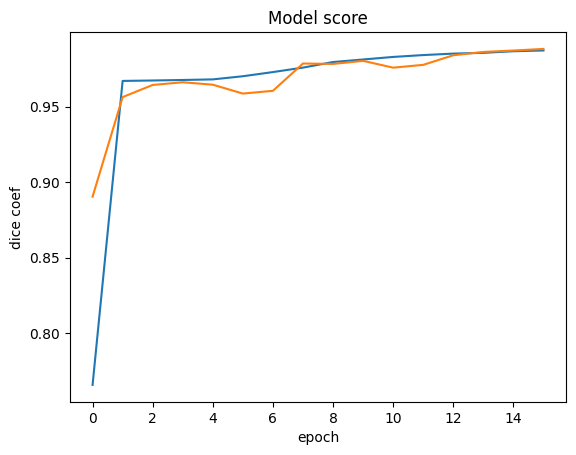

In [23]:
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('Model score')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.show()

**Evaluation**

In [24]:
Y_test_encoded = to_categorical(Y_test)

In [25]:
model.evaluate(X_test, Y_test_encoded)

43/43 [==============================] - 5s 118ms/step - loss: 0.0120 - dice_coef: 0.9880


[0.011957763694226742, 0.9880425333976746]

**Testing**

In [26]:
prediction  = model.predict(X_test)
result = np.argmax(prediction, axis=-1)
Y_pred1 = np.argmax(model.predict(X_test),axis=-1).reshape(-1,192,192,1)
print('Prediction result', result)

43/43 [==============================] - 5s 115ms/step
Prediction result [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [27]:
np.unique(result)

array([0, 1, 2])

In [28]:
result.shape,Y_test.shape,X_test.shape

((1350, 192, 192), (1350, 192, 192, 1), (1350, 192, 192, 4))

In [29]:
Y_pre=result.reshape(-1,192,192,1)

X_test 450


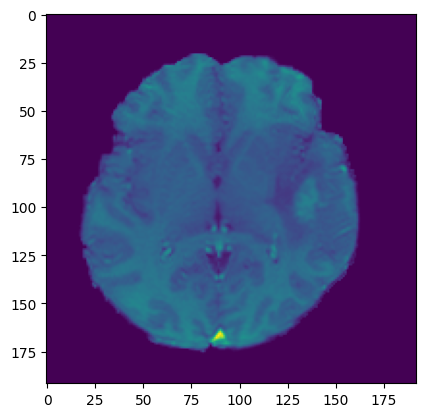

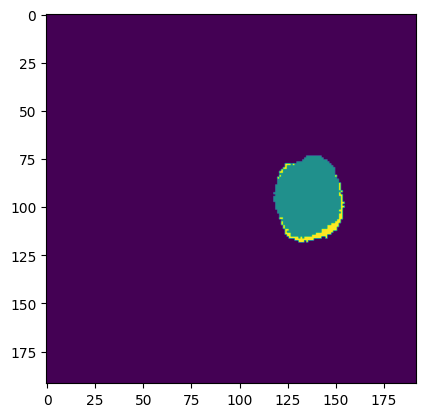

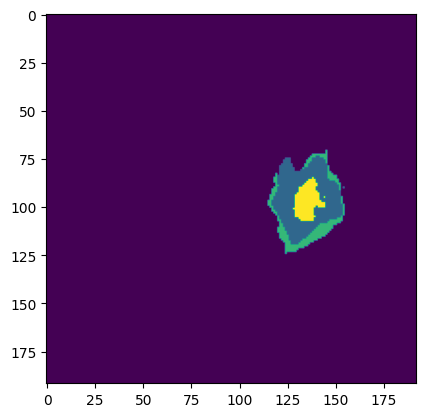

X_test 451


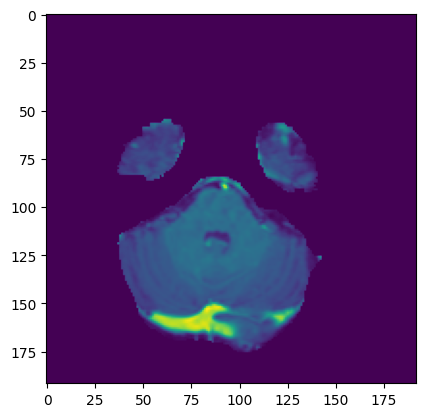

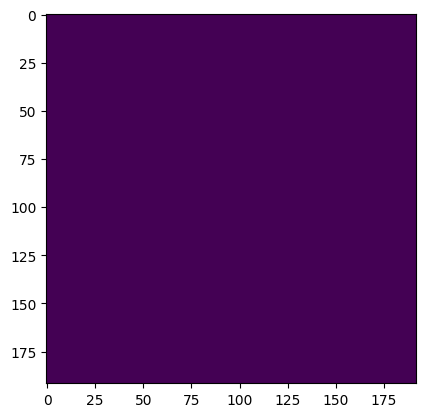

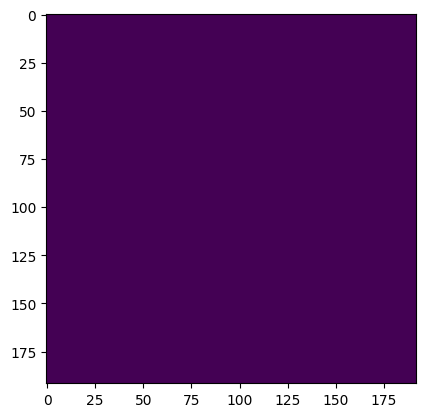

X_test 452


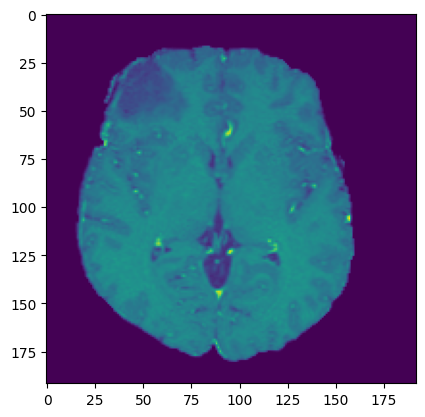

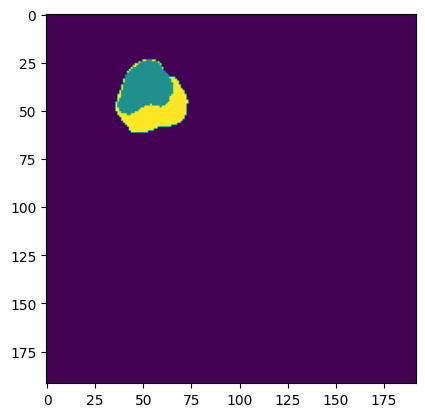

X_test 453


X_test 454


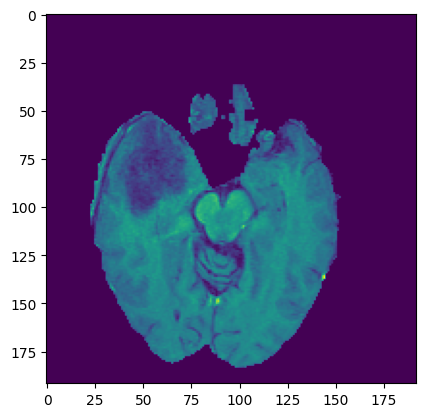

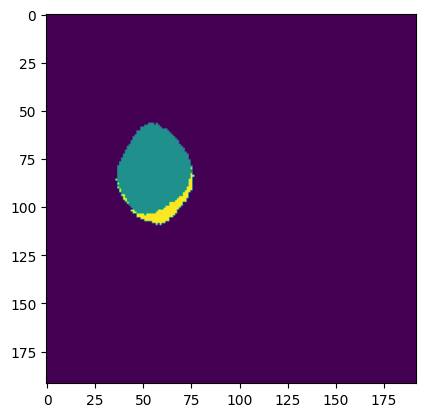

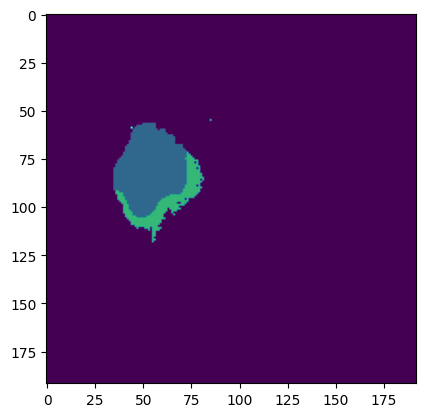

X_test 455


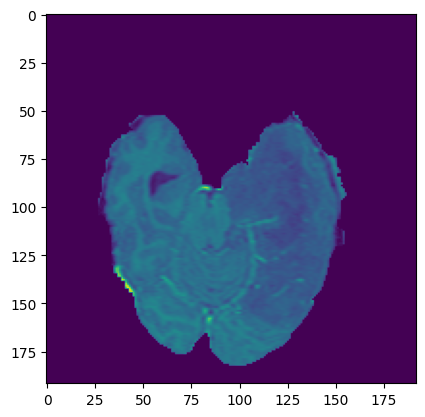

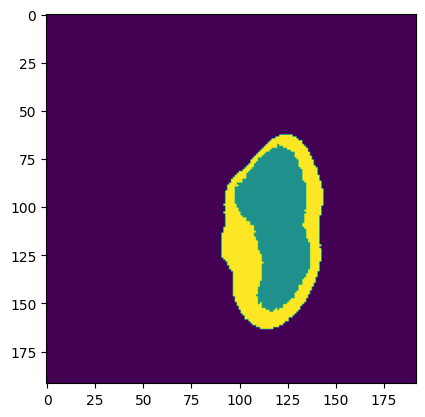

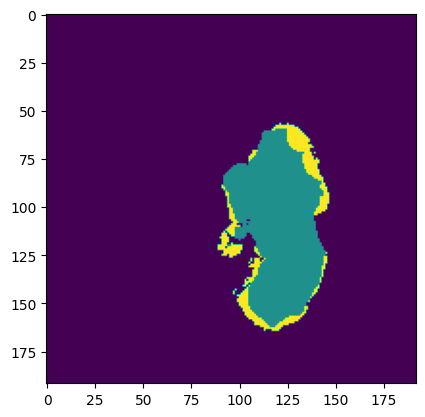

X_test 456


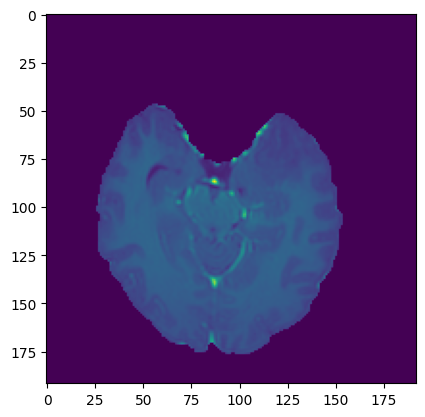

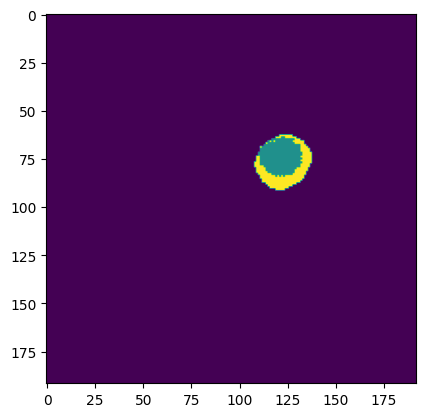

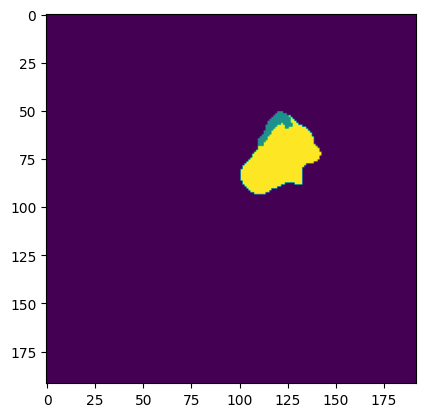

X_test 457


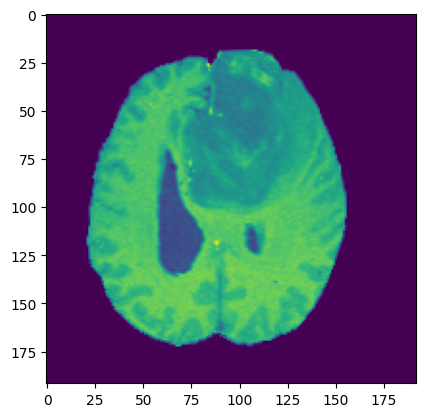

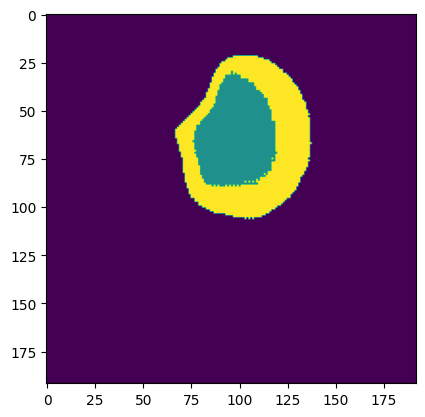

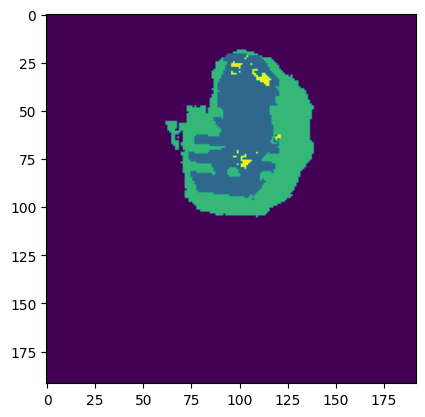

X_test 458


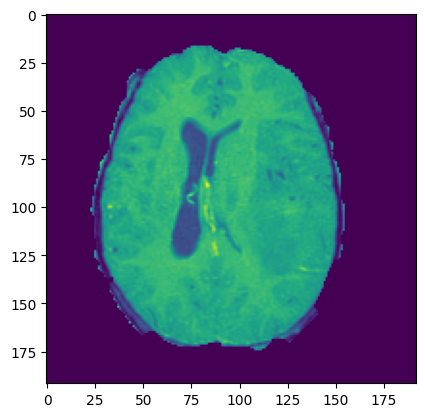

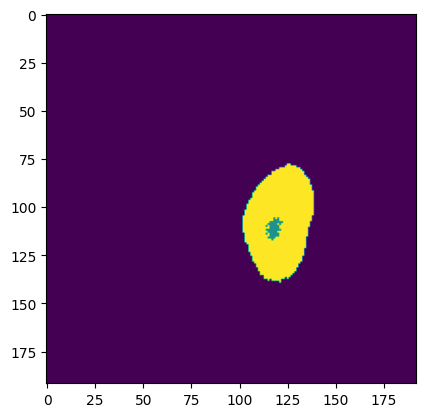

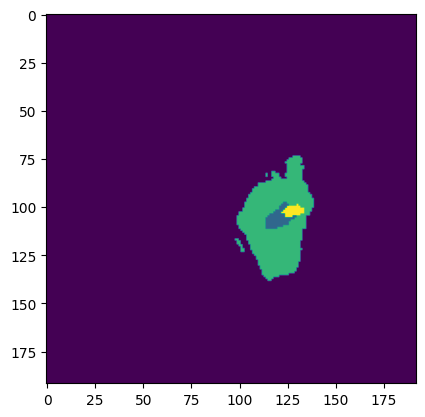

X_test 459


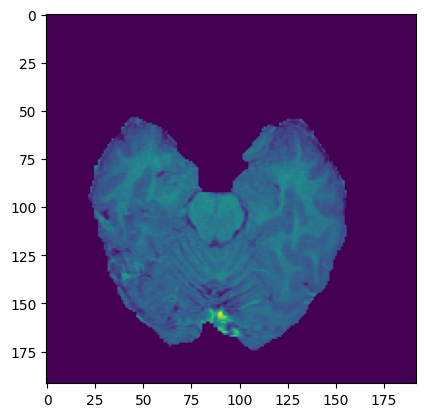

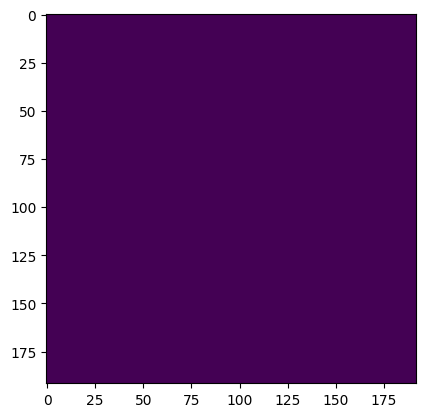

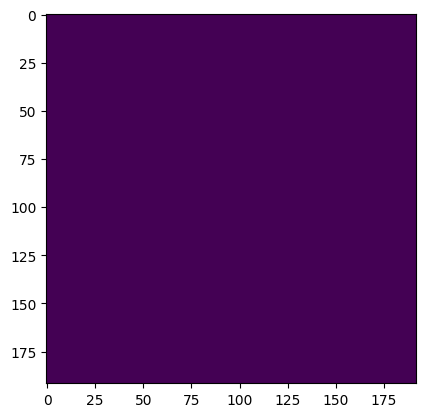

X_test 460


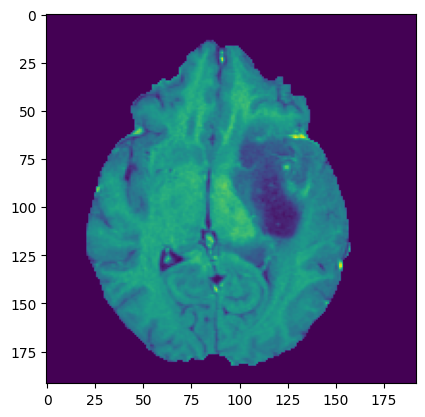

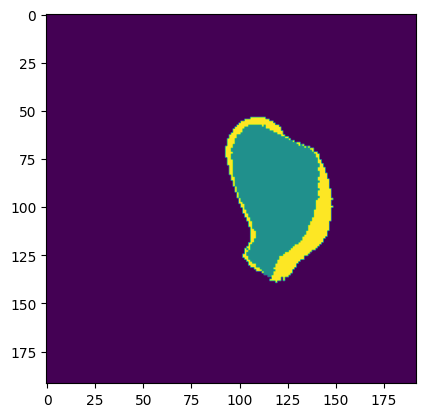

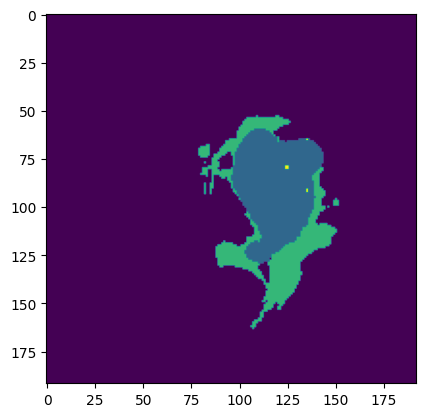

X_test 461


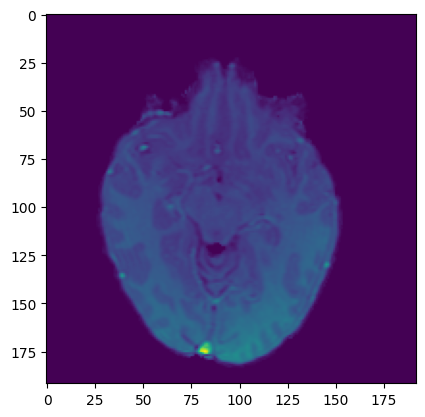

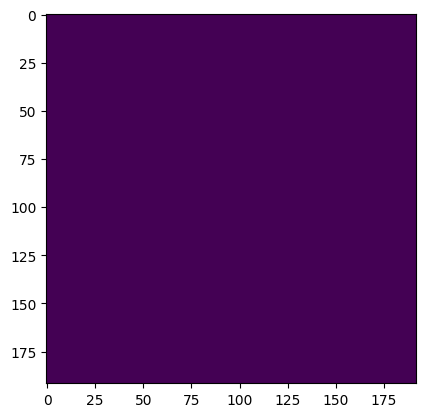

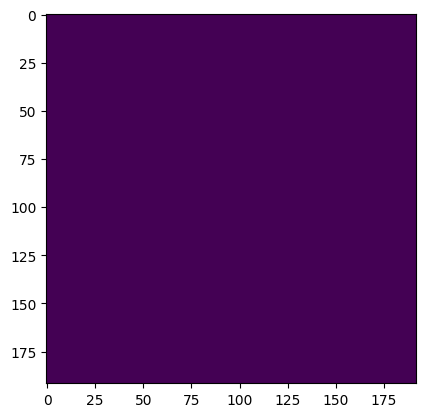

X_test 462


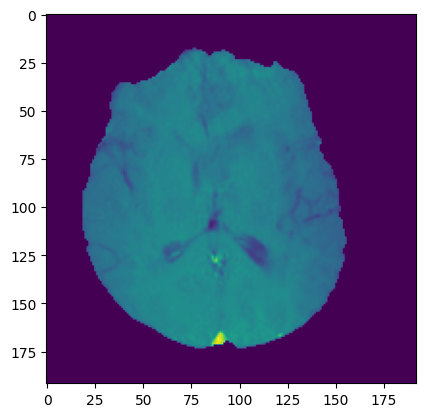

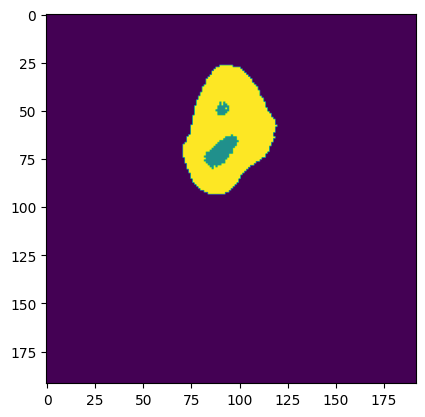

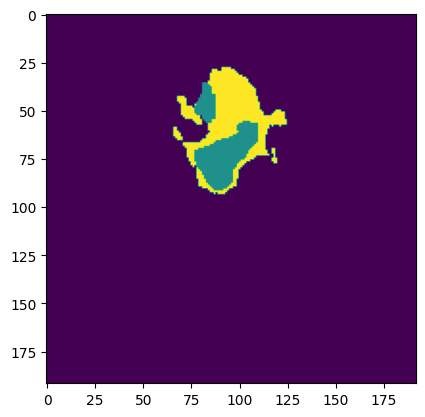

X_test 463


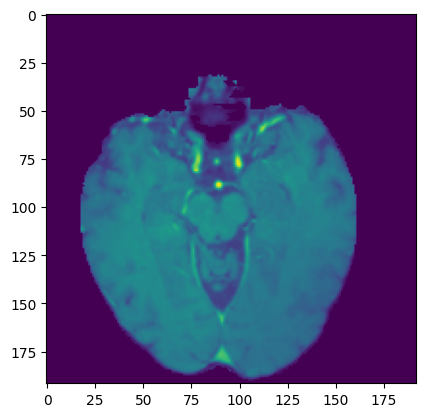

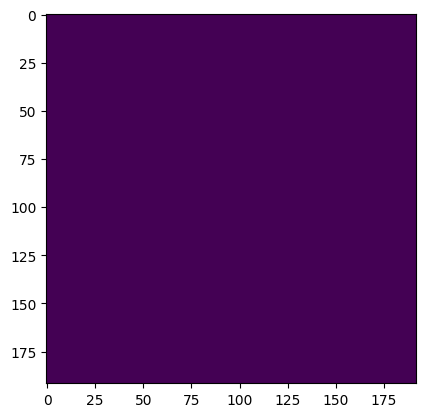

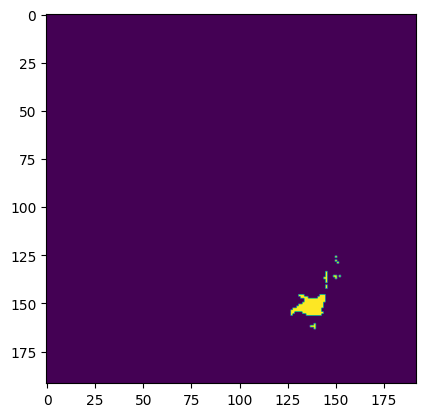

X_test 464


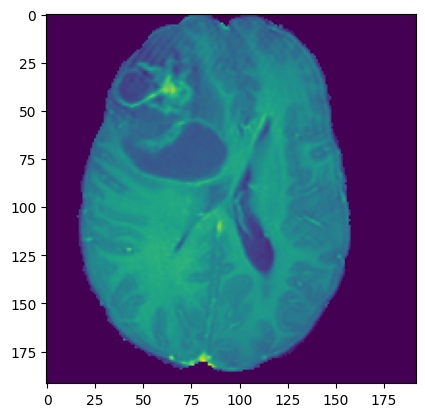

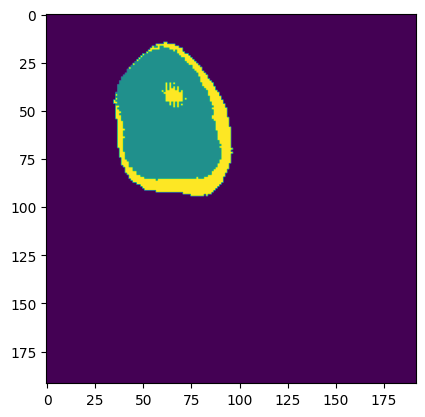

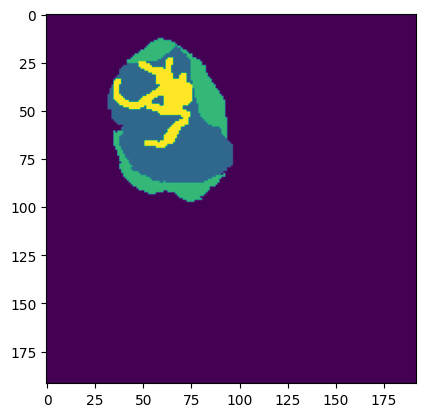

X_test 465


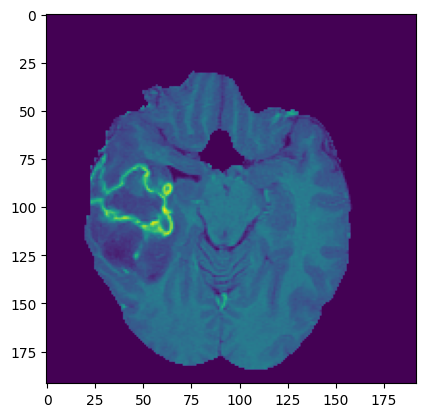

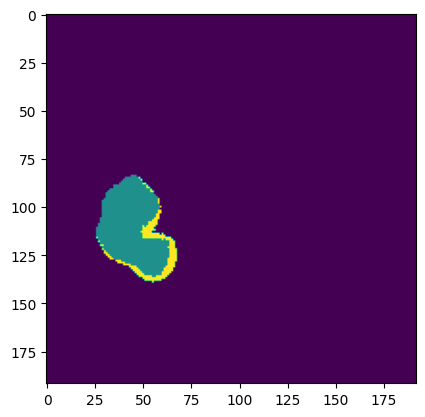

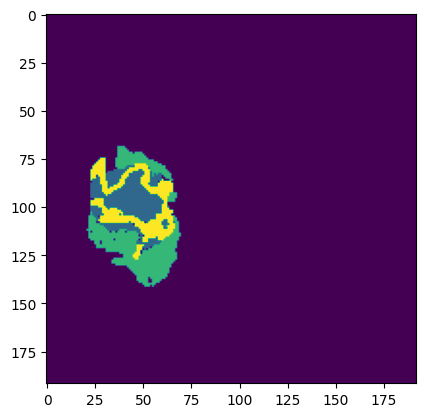

X_test 466


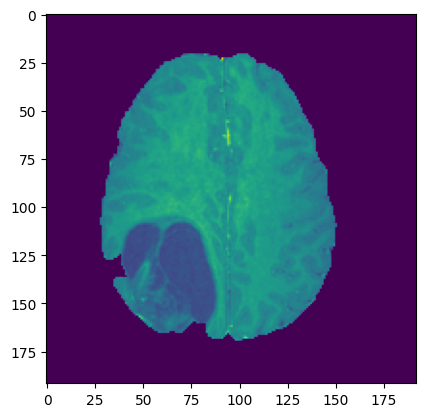

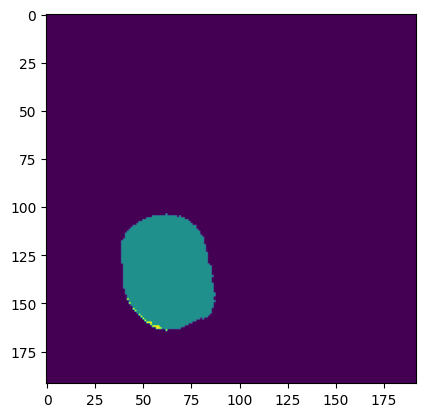

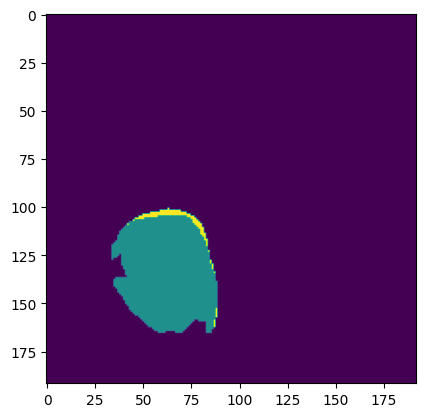

X_test 467


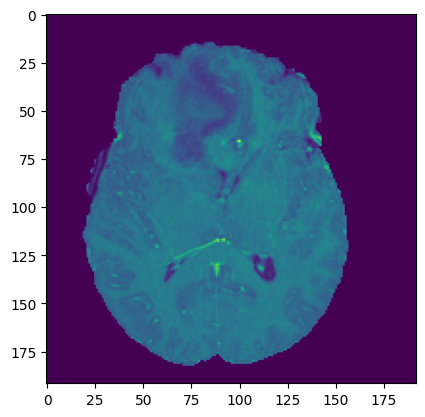

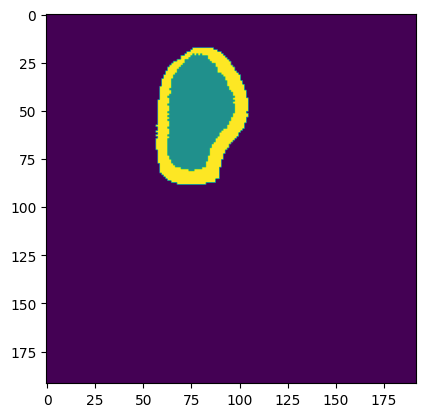

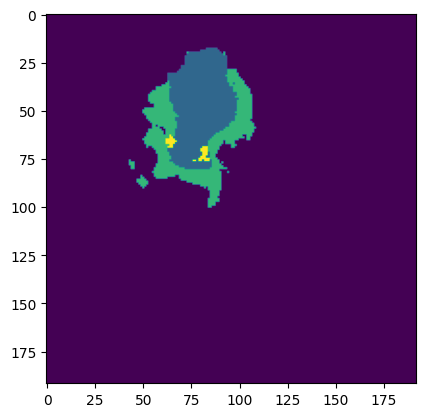

X_test 468


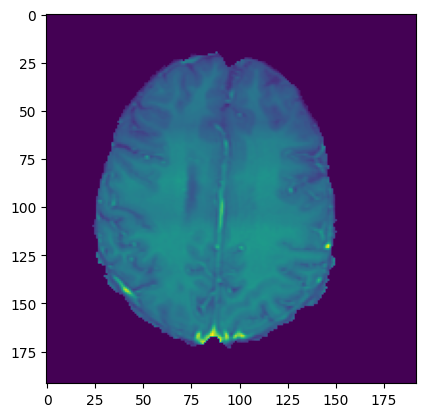

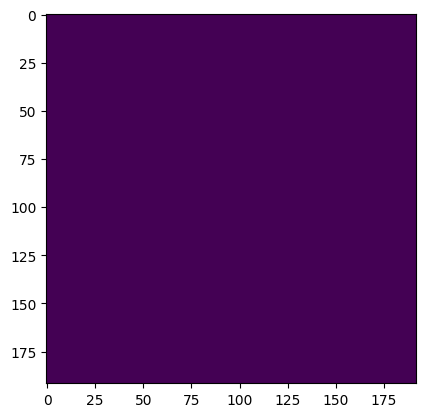

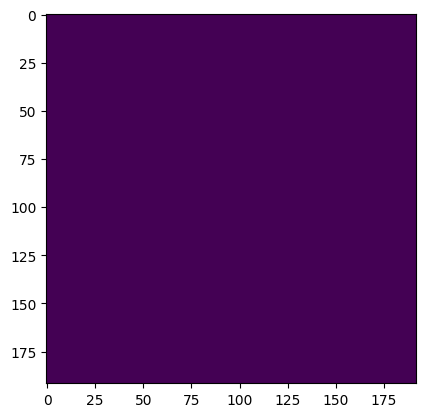

X_test 469


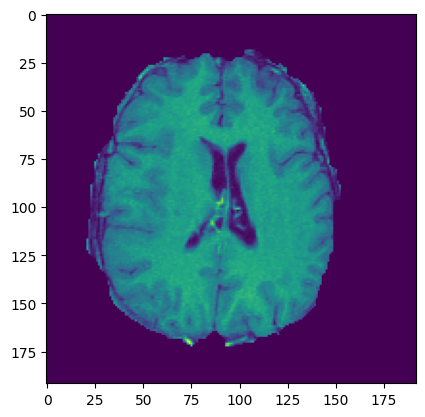

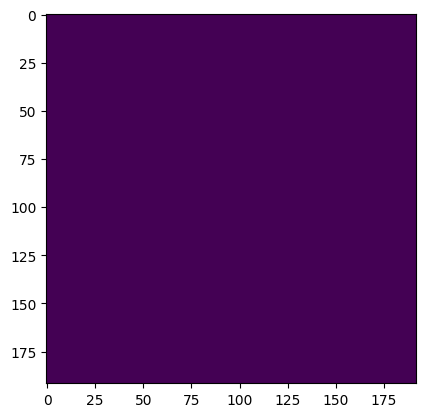

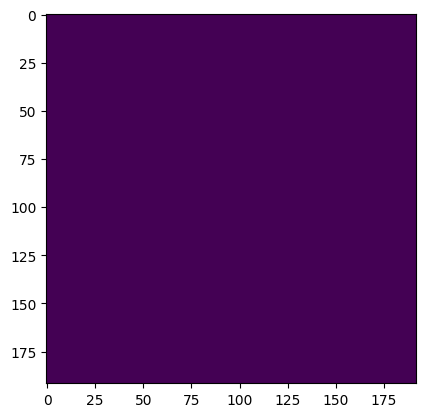

X_test 470


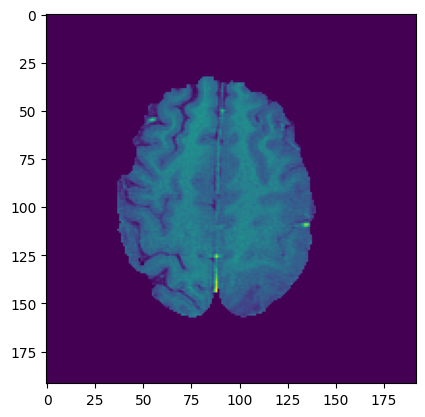

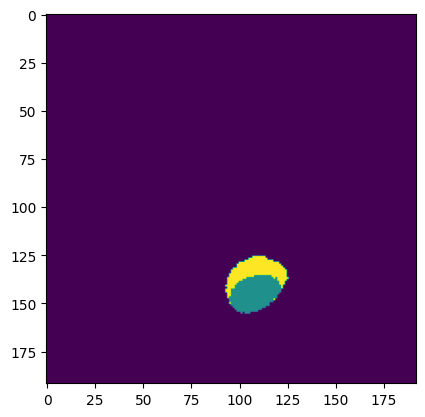

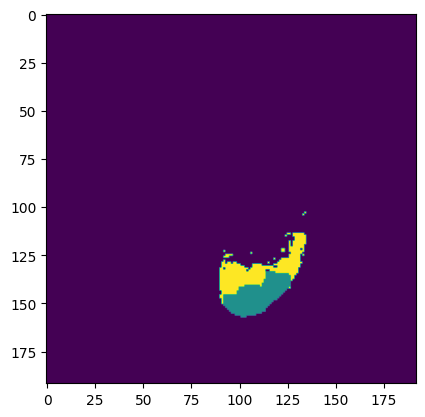

X_test 471


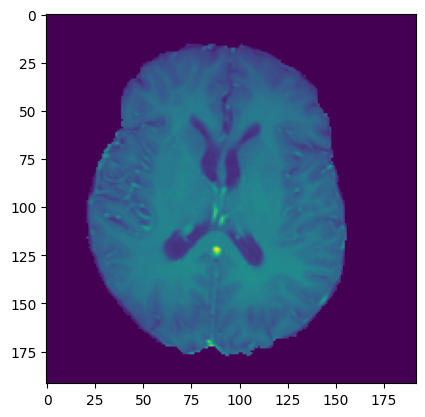

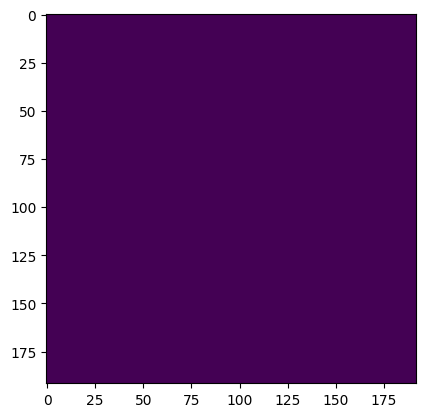

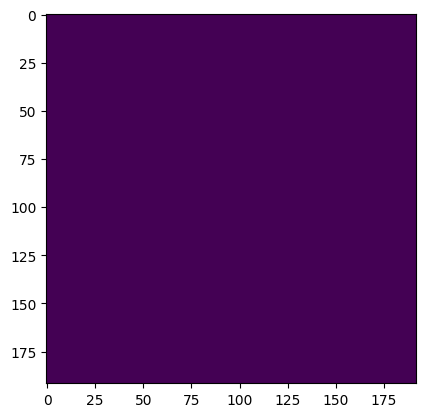

X_test 472


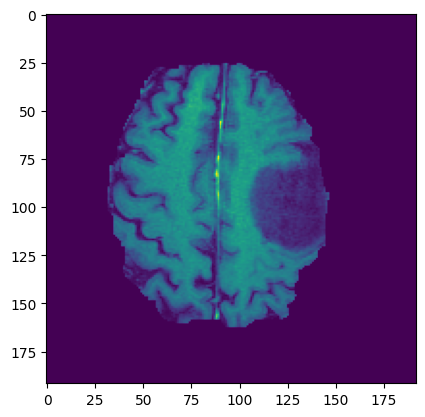

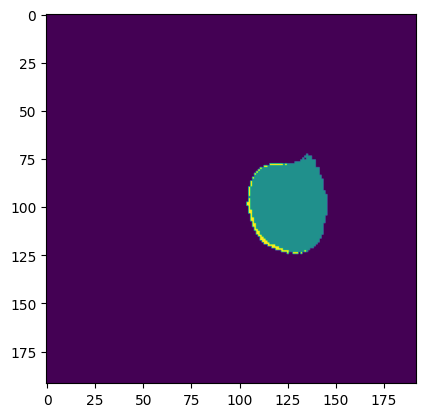

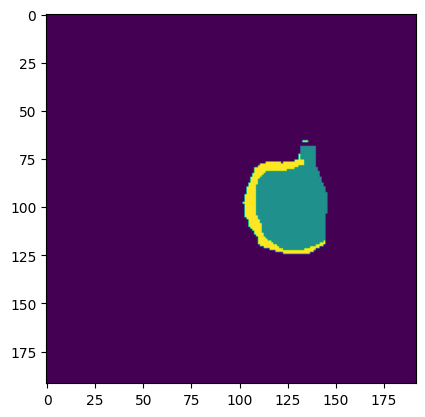

X_test 473


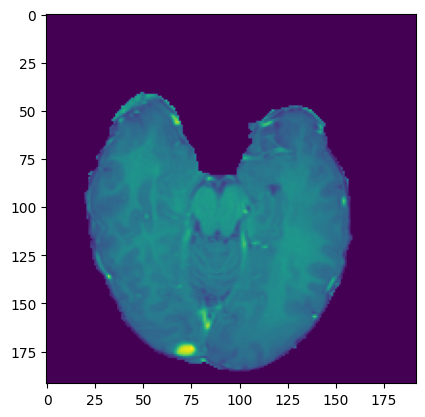

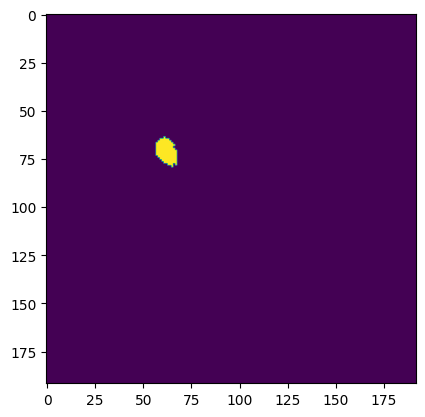

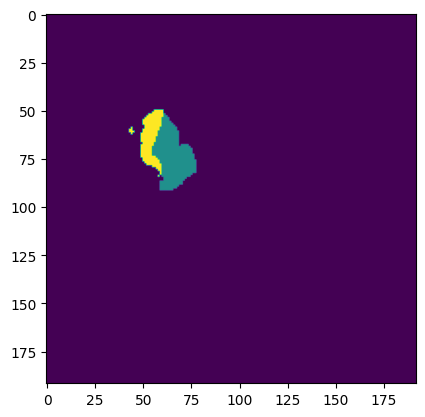

X_test 474


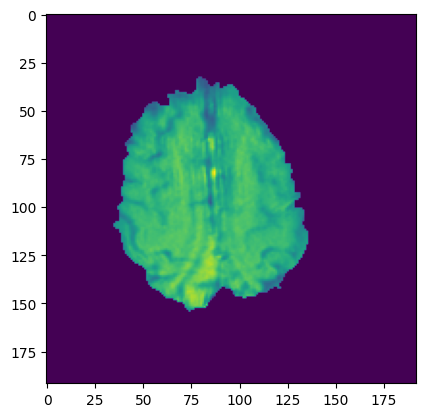

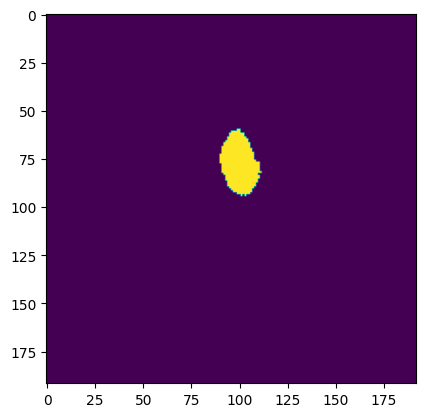

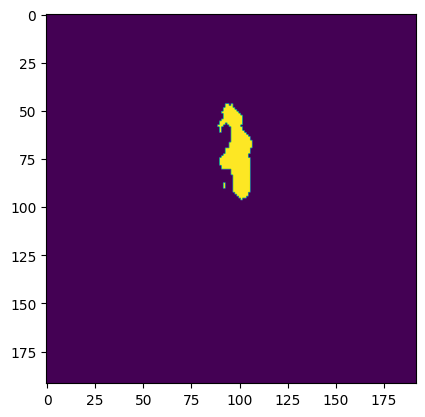

X_test 475


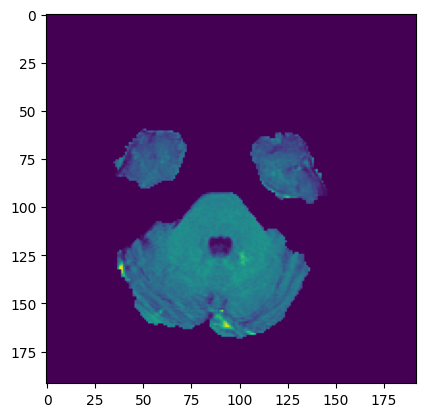

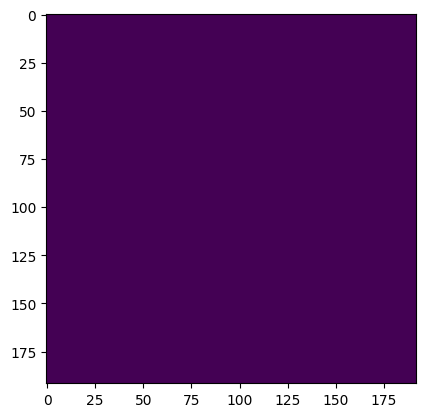

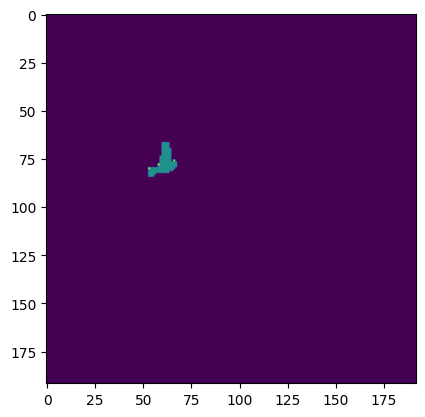

X_test 476


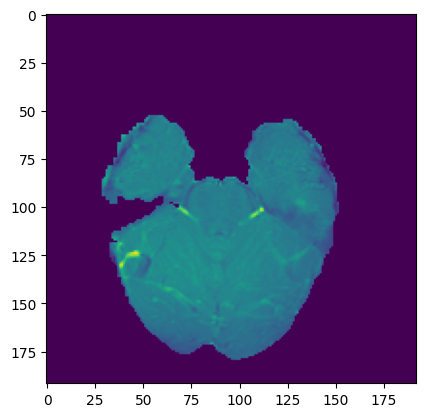

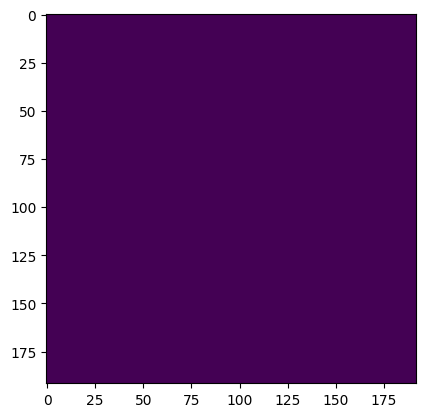

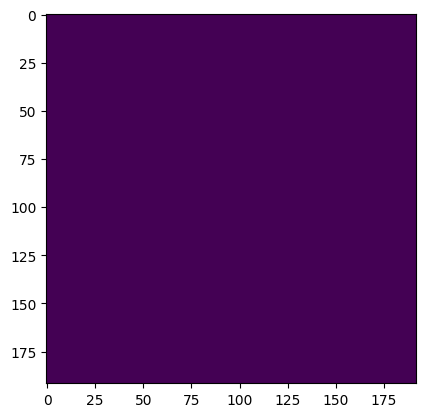

X_test 477


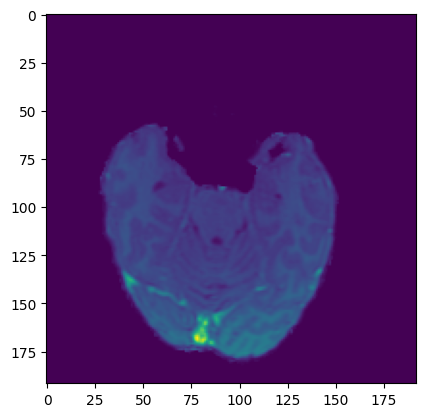

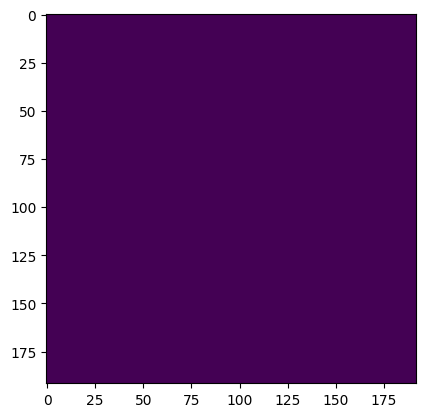

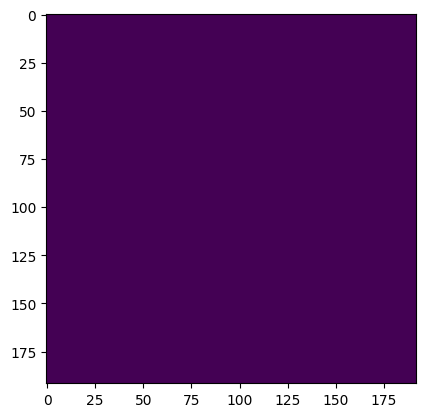

X_test 478


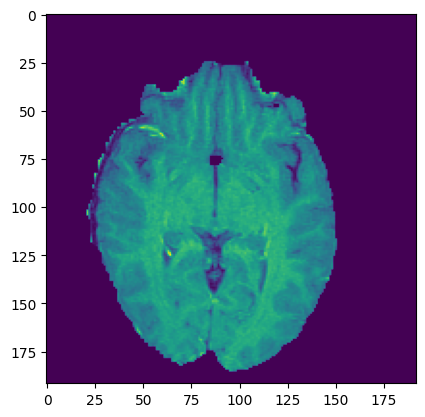

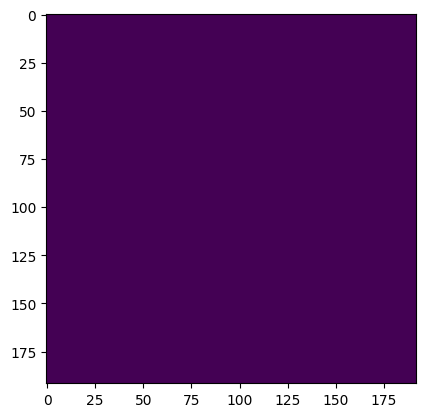

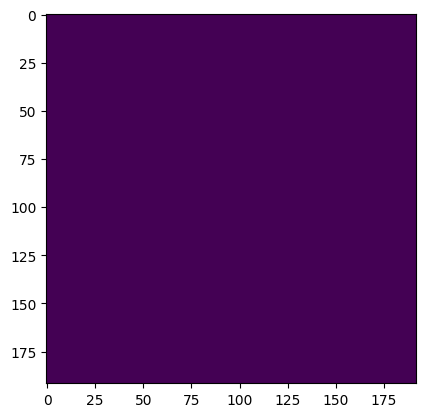

X_test 479


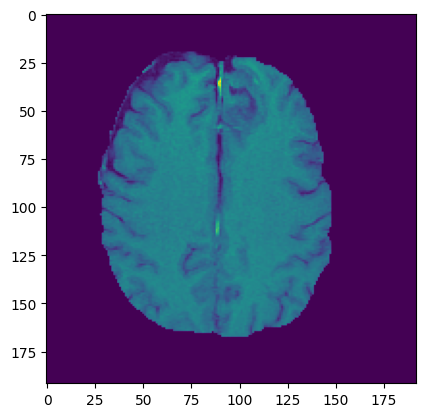

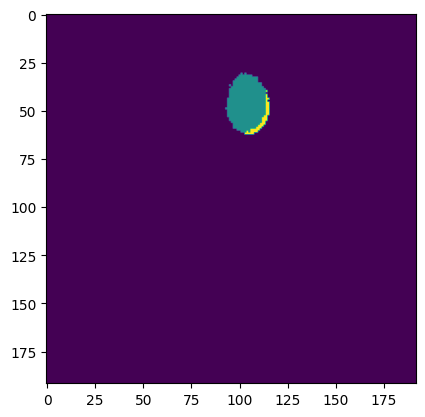

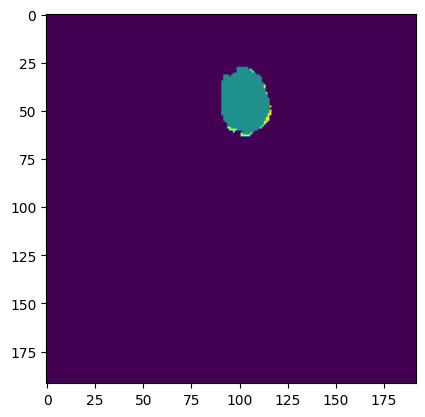

X_test 480


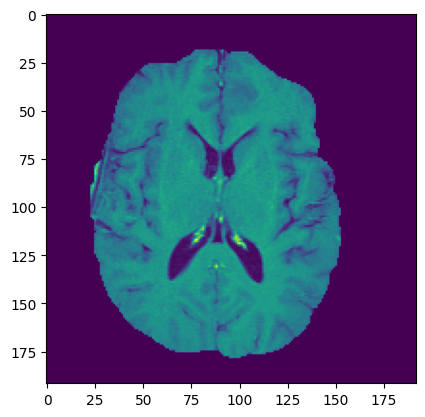

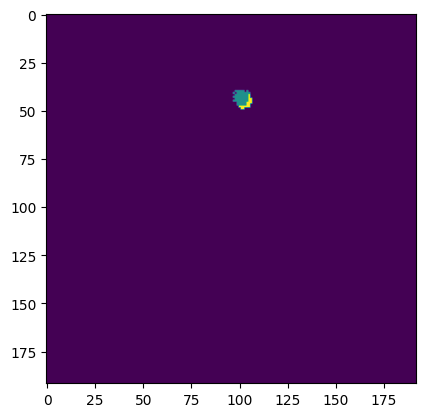

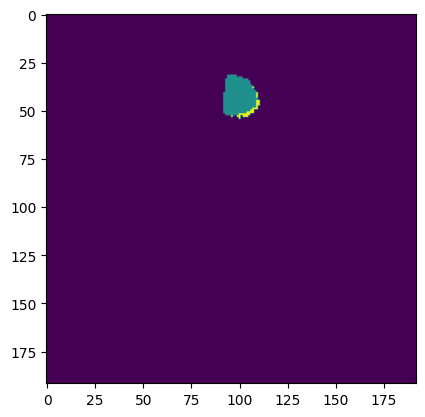

X_test 481


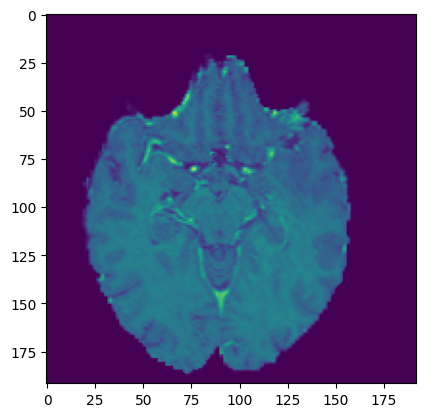

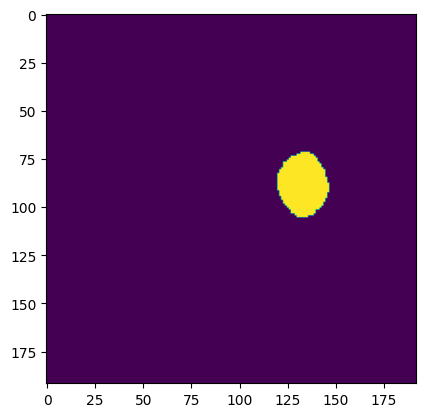

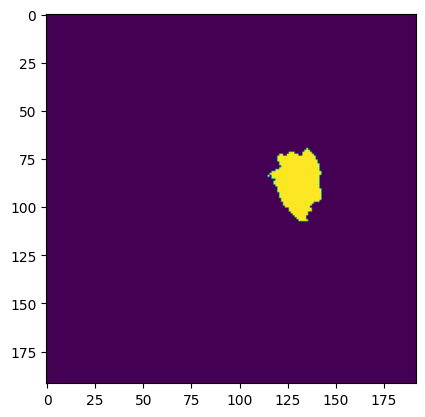

X_test 482


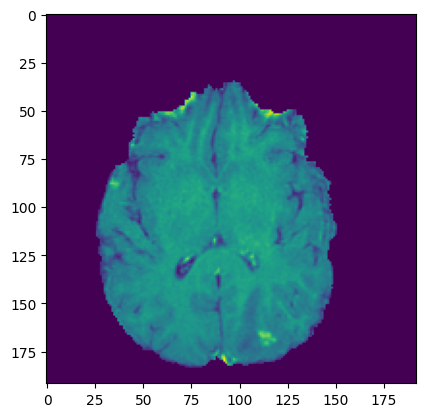

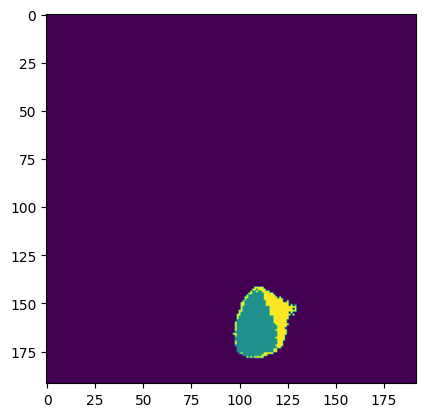

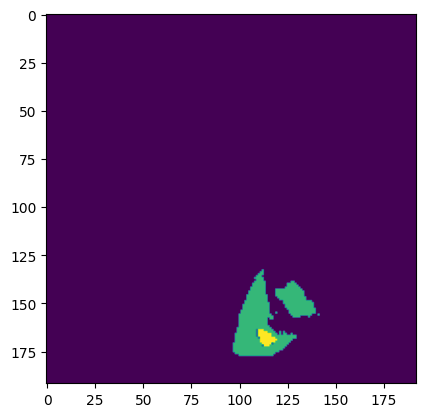

X_test 483


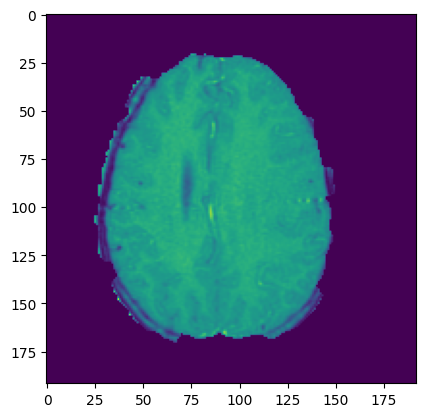

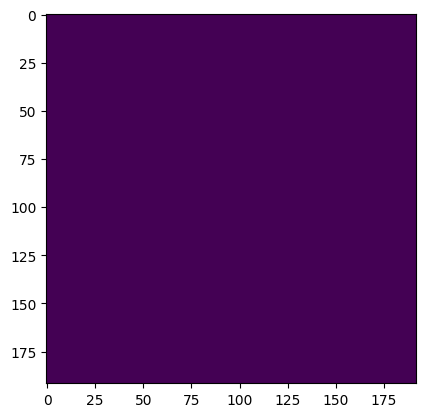

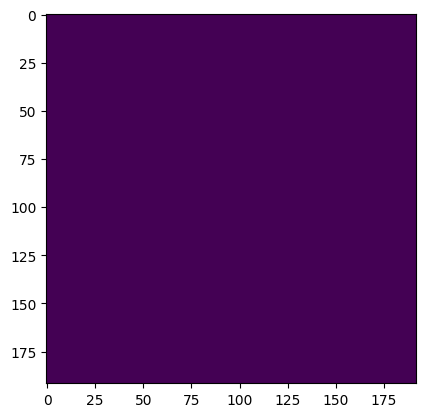

X_test 484


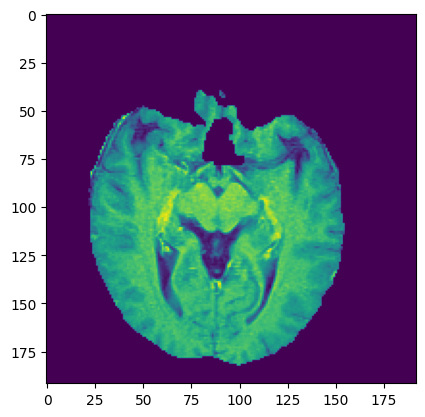

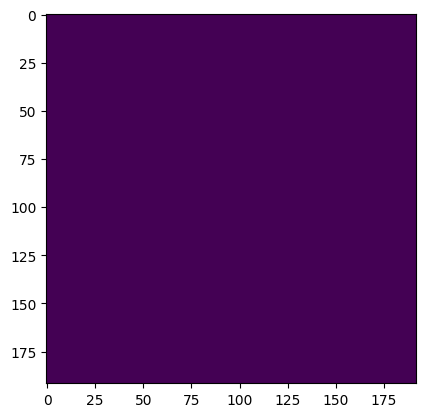

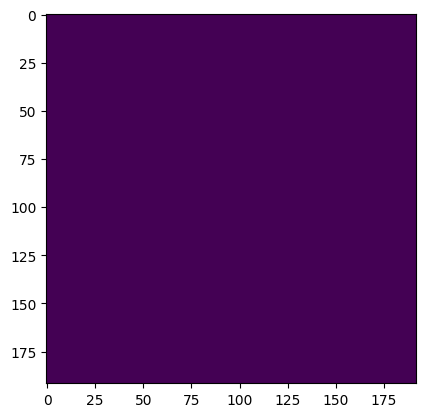

X_test 485


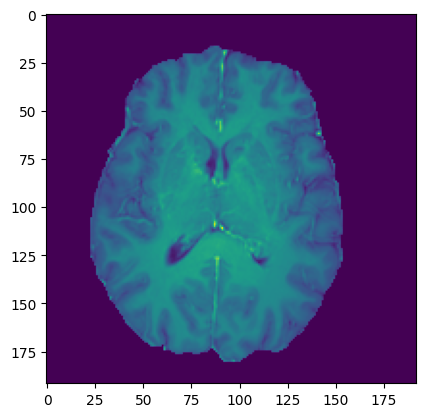

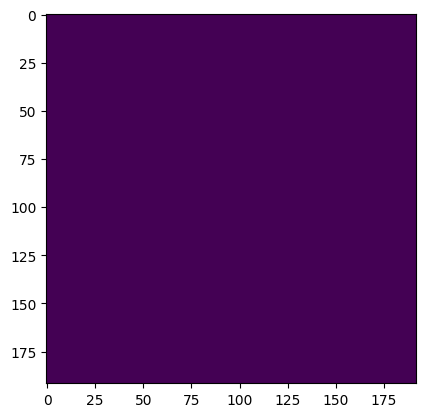

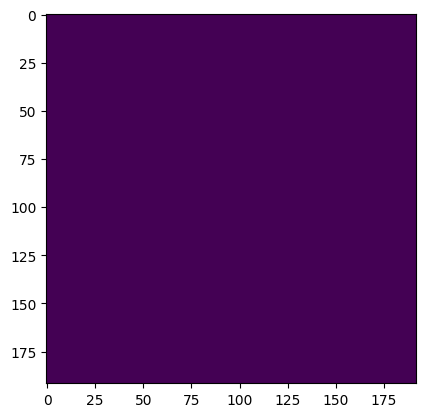

X_test 486


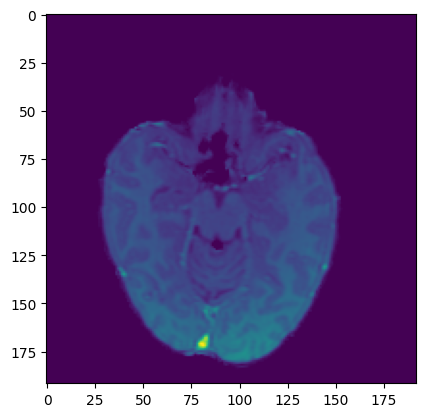

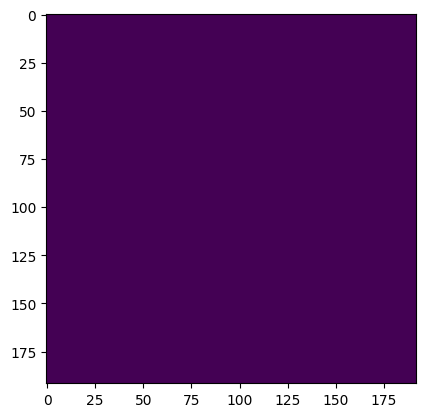

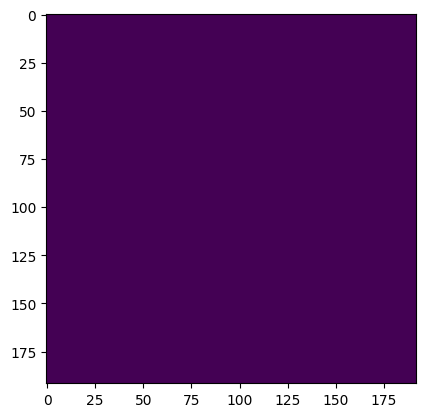

X_test 487


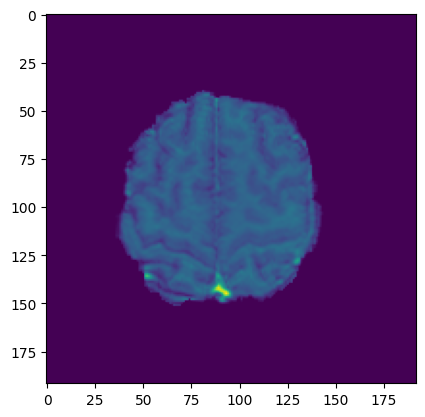

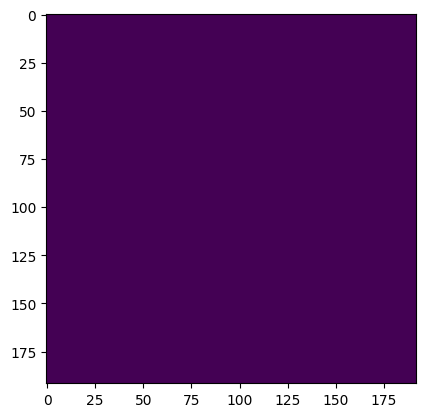

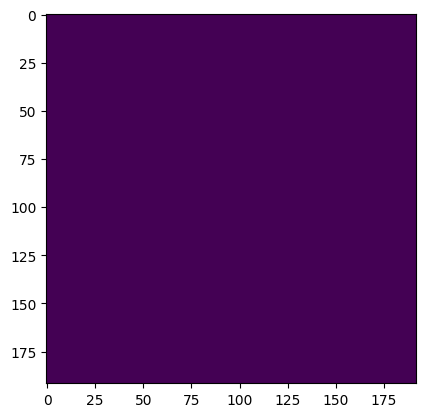

X_test 488


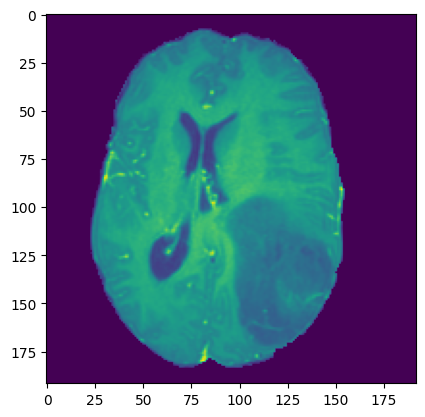

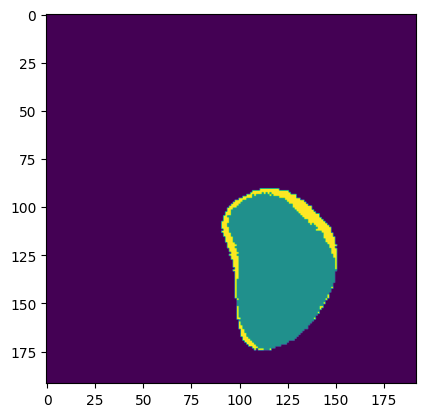

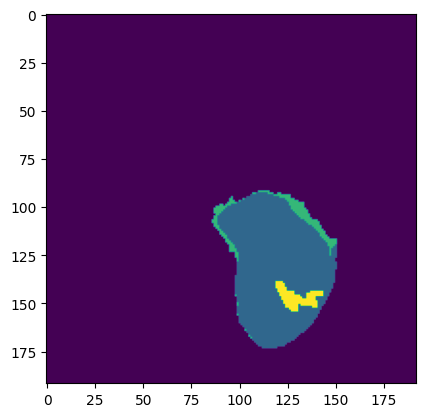

X_test 489


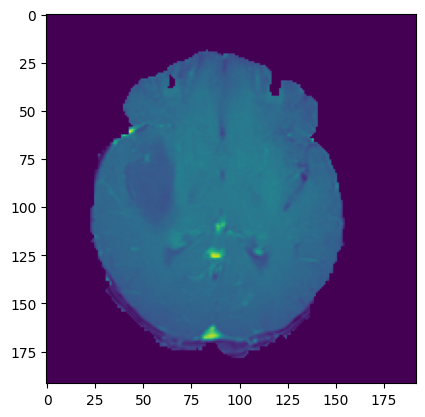

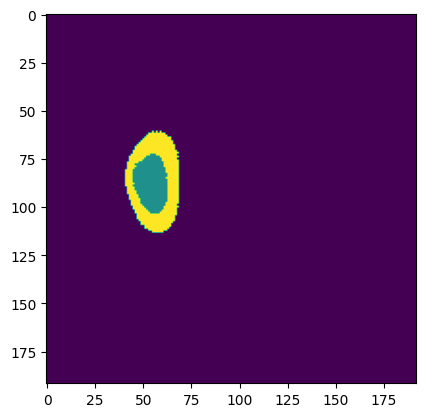

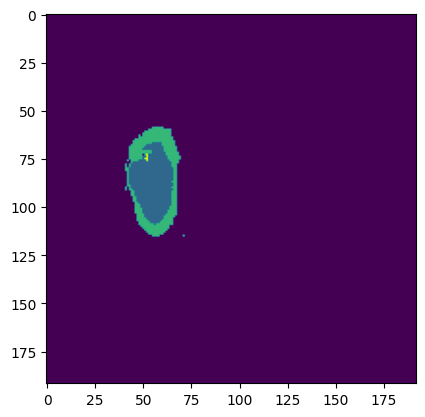

X_test 490


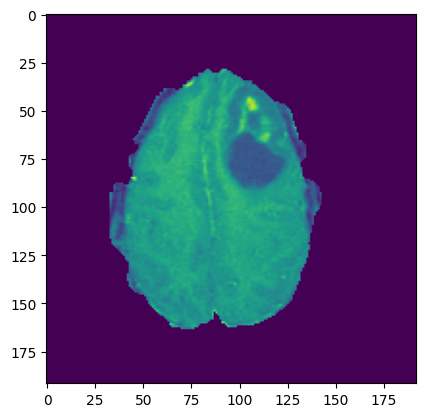

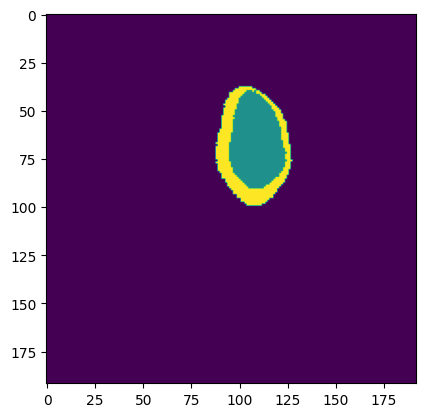

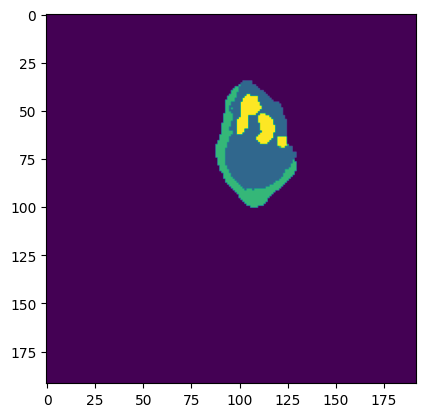

X_test 491


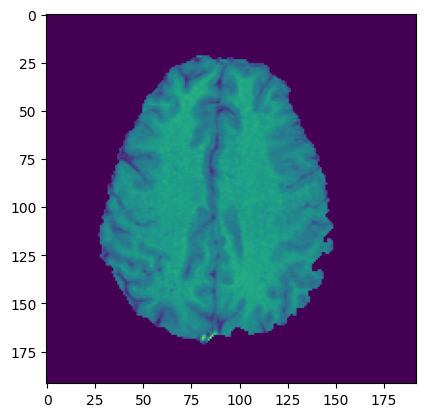

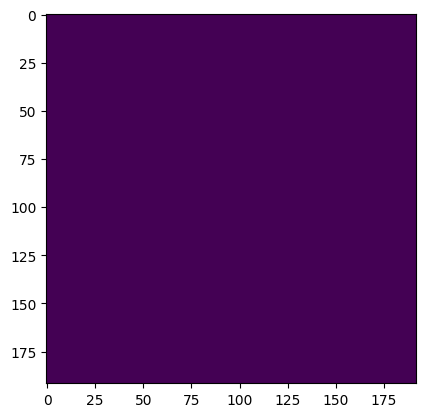

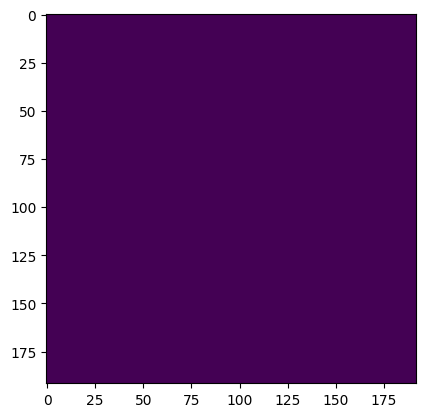

X_test 492


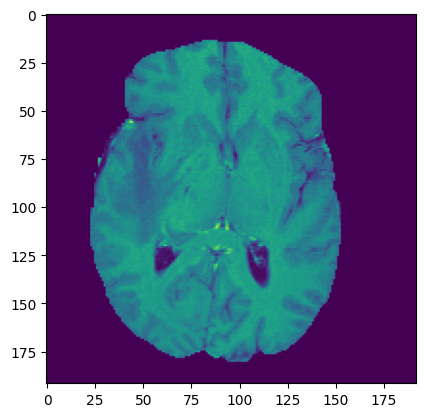

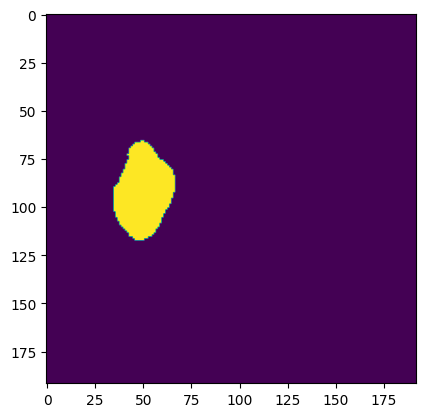

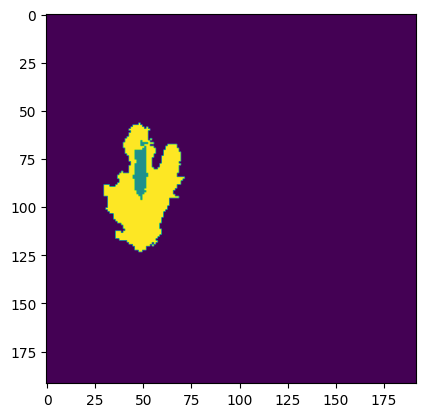

X_test 493


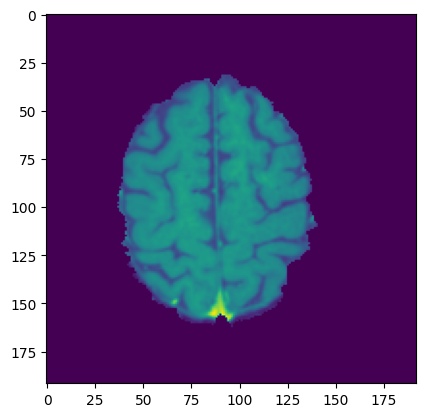

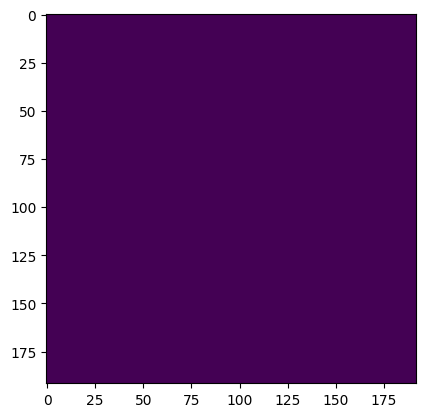

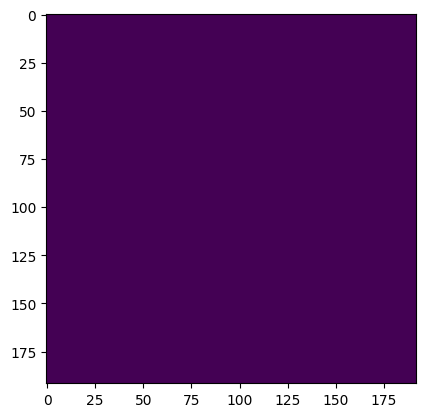

X_test 494


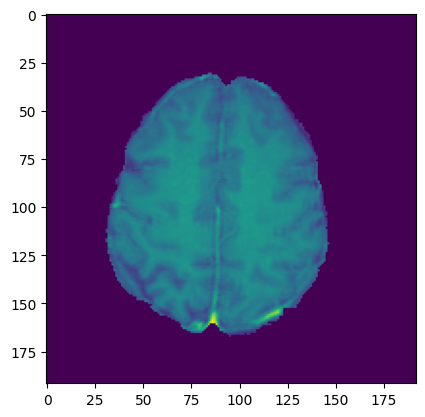

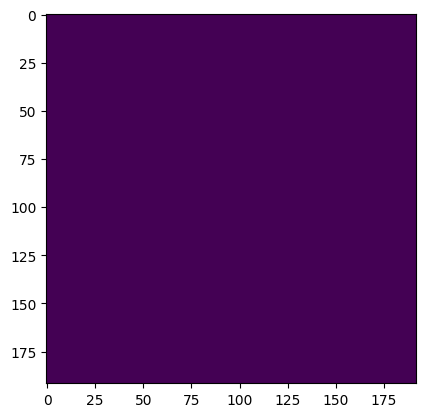

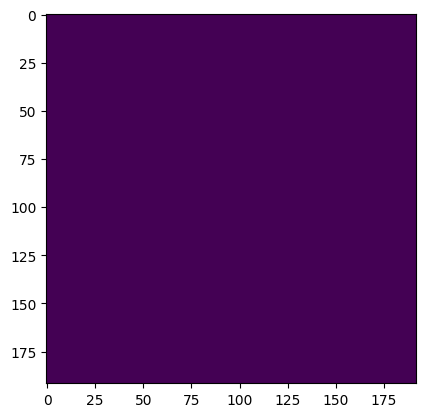

X_test 495


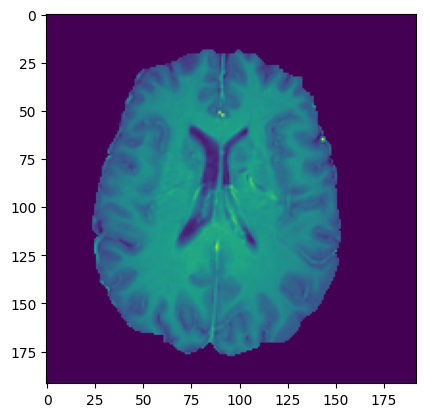

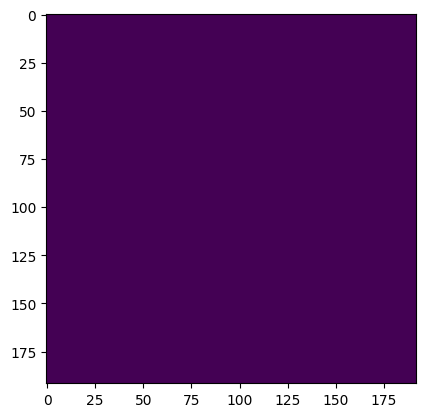

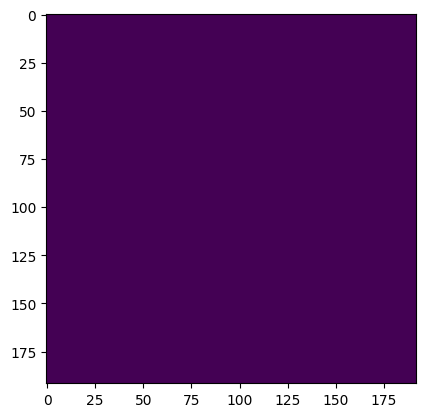

X_test 496


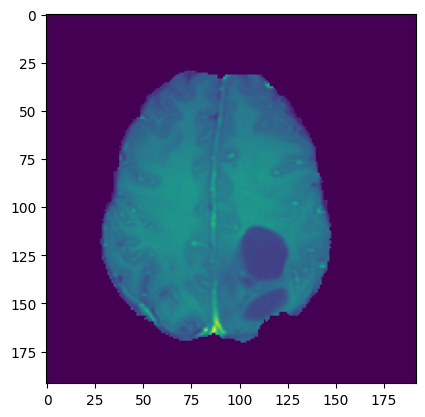

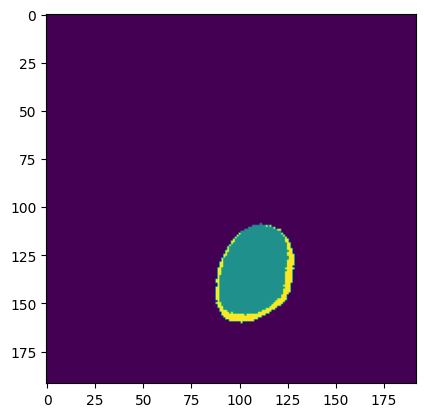

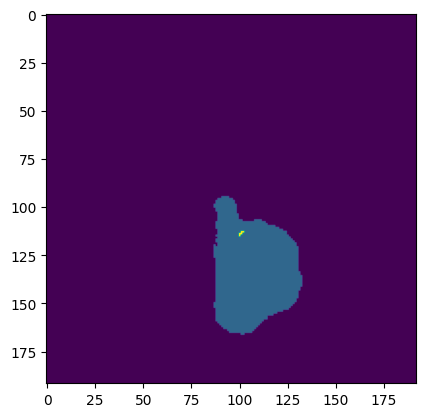

X_test 497


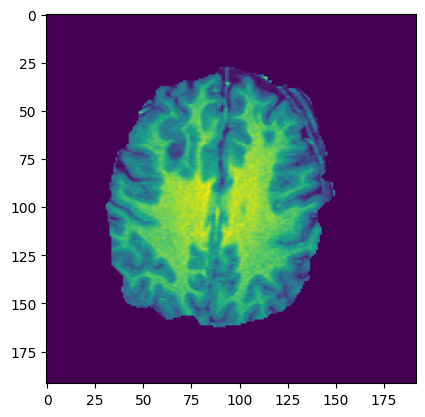

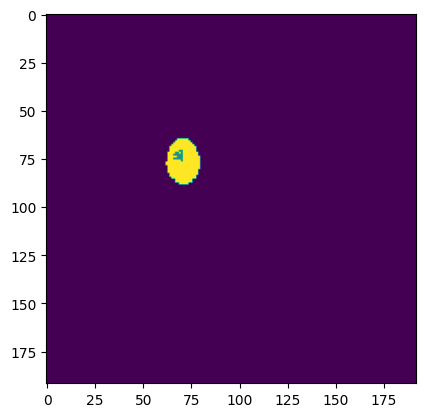

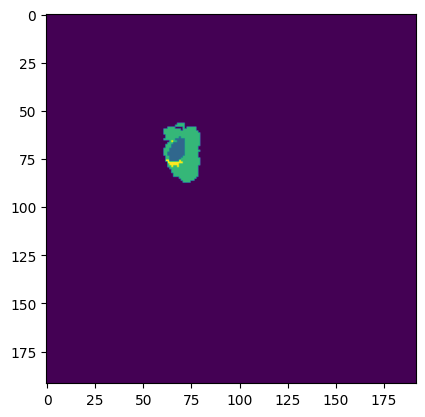

X_test 498


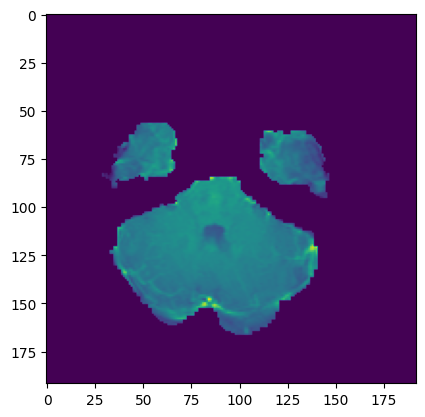

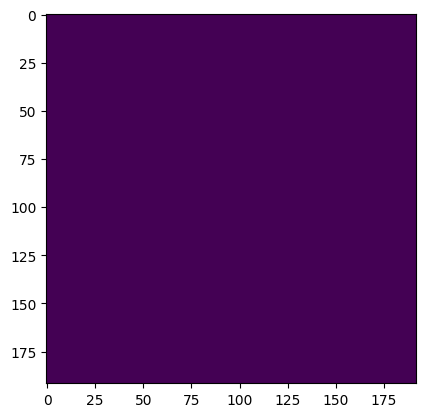

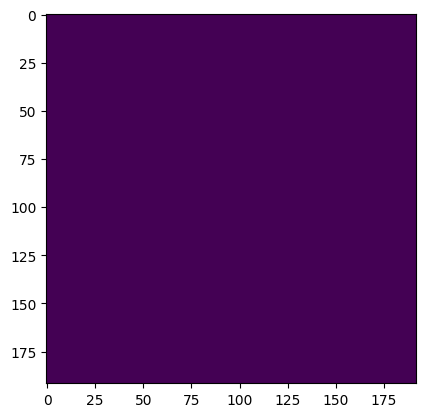

X_test 499


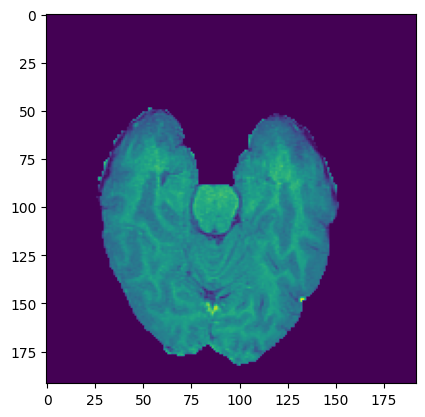

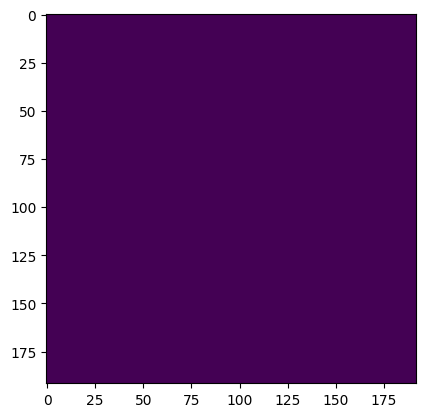

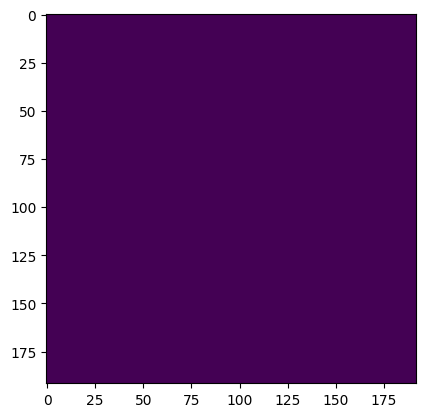

In [30]:
for i in range(450,500):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [31]:
model.save('/content/drive/MyDrive/model.h5',overwrite=True)